<a href="https://colab.research.google.com/github/Monique14041980/FIAP-DATA-ANALYTICS/blob/main/TechChallenge2_revisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*O PROBLEMA:*

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.

Para isso utilize a base de dados contida no site da investing e selecione o período "diário, com o intervalo de tempo que achar adequado.

Você precisará demonstrar para o time de investimentos:

/ O modelo com o storytelling, desde a captura do dado até a entrega do modelo;

/ Justificar a técnica utilizada;

/ Atingir uma acuracidade adequada (acima de 70%).


*Solucoes possiveis:*

Tanto o Prophet quanto o LSTM são modelos populares para previsão de séries temporais, como a bolsa de valores.

Seguem as etapas abaixo primeiramente para modelar em Prophet e depois em LSTM:

#Bibliotecas

https://www.kaggle.com/code/thebrownviking20/everything-you-can-do-with-a-time-series/notebook

https://www.kaggle.com/code/rohanrao/a-modern-time-series-tutorial

https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm

In [269]:
!pip install --upgrade statsmodels

In [270]:
# Bibliotecas básicas de data science.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf, plot_predict
from statsmodels.tsa.stattools import pacf, acf
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from pandas.plotting import autocorrelation_plot,lag_plot
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

#Para deep learning.
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.metrics import MeanSquaredError
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings
warnings.filterwarnings('ignore')

#Prophet.
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric


#formatando valores com duas casas decimais.
pd.options.display.float_format = '{:.2f}'.format
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,9
sns.set_style("whitegrid")



#Importação dos dados

Realizamos a importação dos dados do índice Bovespa dos anos de 2019 a 2023, através da bilioteca yfinance

In [271]:
import yfinance as yf

# identificando o índice e o período selecionado.
symbol = '^BVSP'
start_date = '2018-01-01'
end_date = '2023-12-31'

# download dos dados.
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [272]:

df.head()

Open     High      Low    Close  Adj Close   Volume
Date                                                              
2018-01-02 76403.00 77909.00 76403.00 77891.00   77891.00  2880300
2018-01-03 77889.00 78414.00 77602.00 77995.00   77995.00  3142200
2018-01-04 77998.00 79135.00 77998.00 78647.00   78647.00  3486100
2018-01-05 78644.00 79071.00 78218.00 79071.00   79071.00  2747100
2018-01-08 79070.00 79395.00 78631.00 79379.00   79379.00  2550800

#Análise dos dados

In [273]:
df.shape

(1486, 6)

In [274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1486 entries, 2018-01-02 to 2023-12-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1486 non-null   float64
 1   High       1486 non-null   float64
 2   Low        1486 non-null   float64
 3   Close      1486 non-null   float64
 4   Adj Close  1486 non-null   float64
 5   Volume     1486 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 81.3 KB


In [275]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

#Feature Engineering

In [276]:
df.drop(['Adj Close','Volume'], axis=1, inplace=True)

In [277]:
df.index.name = 'ds'

In [278]:
df

Open      High       Low     Close
ds                                                
2018-01-02  76403.00  77909.00  76403.00  77891.00
2018-01-03  77889.00  78414.00  77602.00  77995.00
2018-01-04  77998.00  79135.00  77998.00  78647.00
2018-01-05  78644.00  79071.00  78218.00  79071.00
2018-01-08  79070.00  79395.00  78631.00  79379.00
...              ...       ...       ...       ...
2023-12-21 130826.00 132277.00 130822.00 132182.00
2023-12-22 132553.00 133035.00 132094.00 132753.00
2023-12-26 132753.00 133645.00 132753.00 133533.00
2023-12-27 133523.00 134195.00 133328.00 134194.00
2023-12-28 134194.00 134392.00 133832.00 134185.00

[1486 rows x 4 columns]

Observando a correlação dos dados do dataset.

<Axes: >

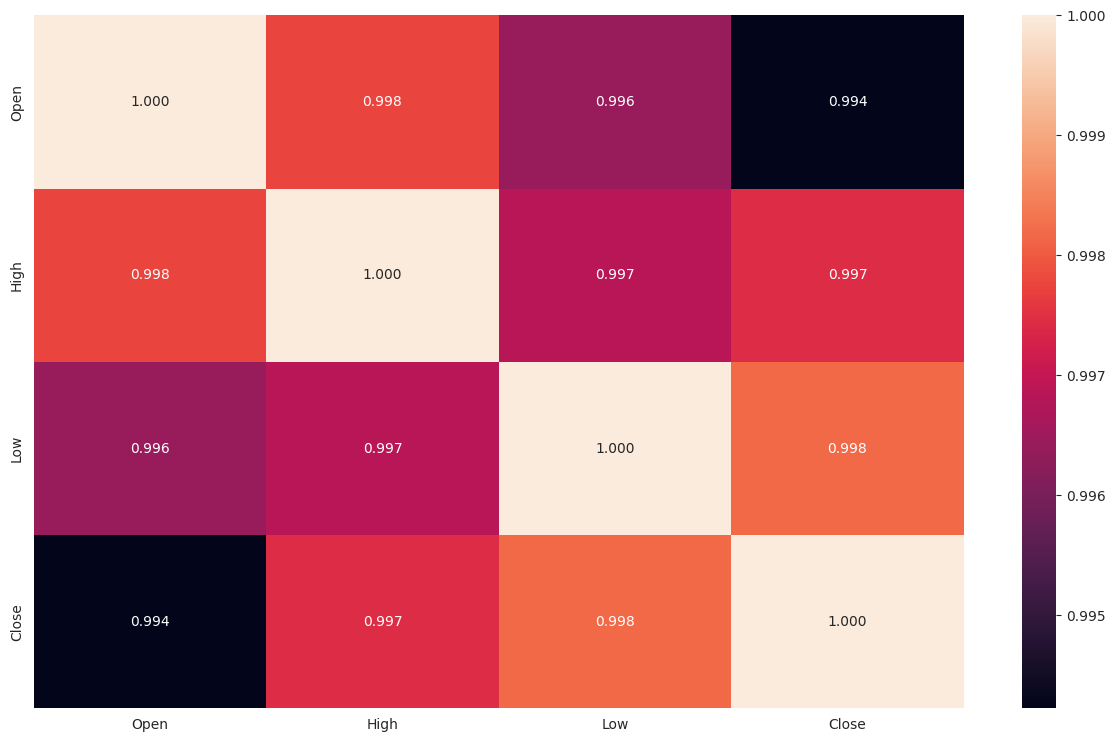

In [279]:
correlacao = df.corr()
sns.heatmap(correlacao, annot=True, fmt='.3f')

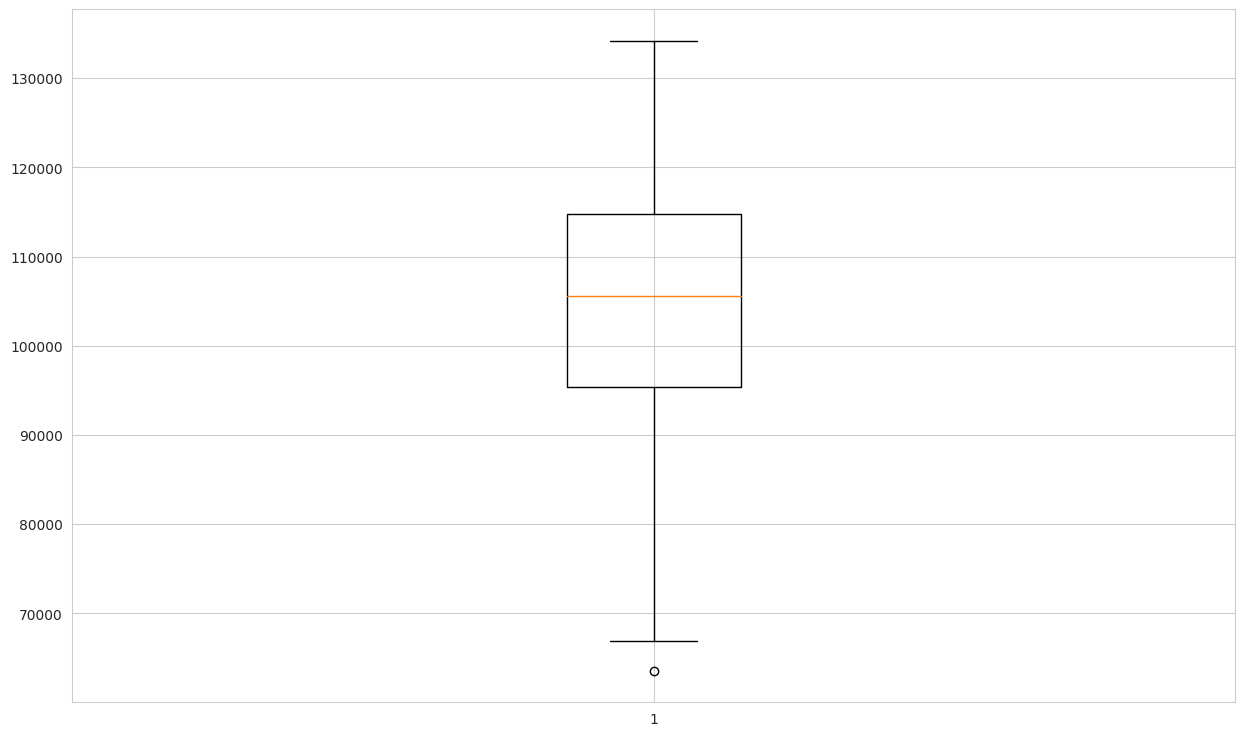

In [280]:
plt.boxplot(df['Close'])
plt.show()

Criando uma nova coluna com a variação diária de valores de fechamento.

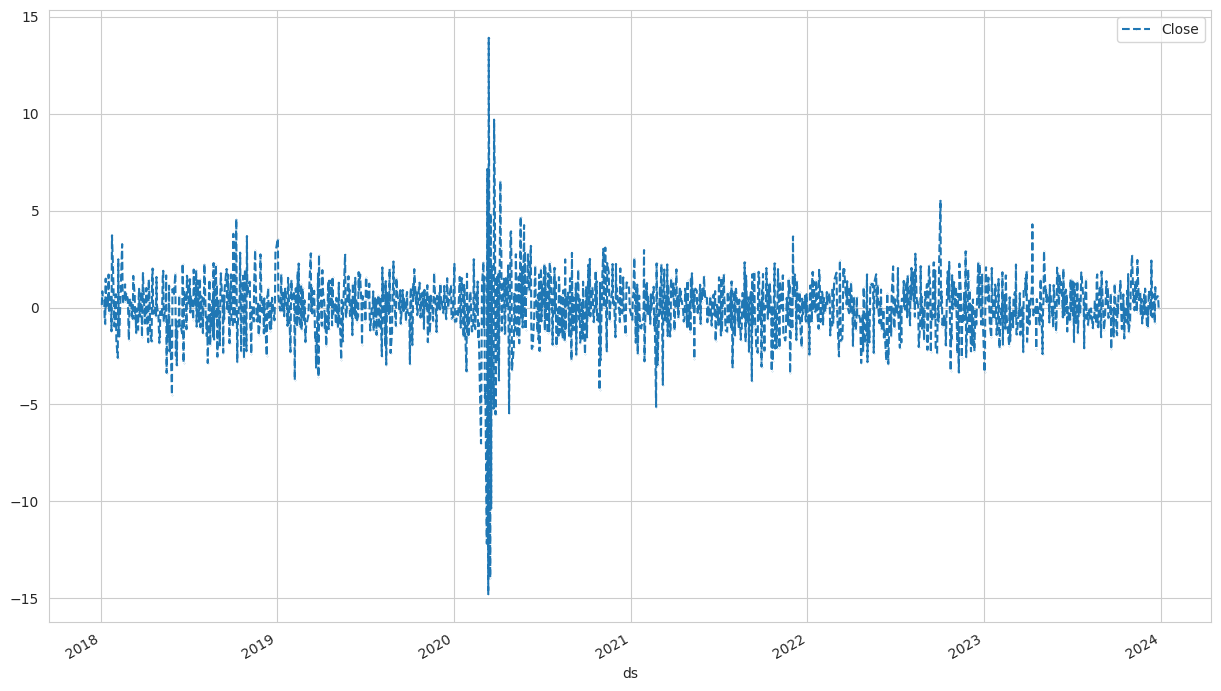

In [281]:
# Calculando o percentual de mudança na cotação de fechamento diário do índice Bovespa.

retorno_diario = df["Close"].dropna().pct_change()*100
retorno_diario.plot(legend=True, linestyle='--', marker='o', markersize=0.1)
plt.show()

Observamos que há uma enorme alteração nos dados em 2020, provavelmente em virtude da pandemia de COVID que afetou a economia global.

In [282]:
#fazendo o merge dos dados.
df_completo = pd.merge( df, retorno_diario, how = 'inner', on = 'ds')
df_completo.columns = ['Open','High','Low','Close','Variation(%)']
df_completo.head()

Open     High      Low    Close  Variation(%)
ds                                                          
2018-01-02 76403.00 77909.00 76403.00 77891.00           NaN
2018-01-03 77889.00 78414.00 77602.00 77995.00          0.13
2018-01-04 77998.00 79135.00 77998.00 78647.00          0.84
2018-01-05 78644.00 79071.00 78218.00 79071.00          0.54
2018-01-08 79070.00 79395.00 78631.00 79379.00          0.39

In [283]:
df_completo.describe().T

count      mean      std      min      25%       50%       75%  \
Open         1486.00 103619.65 14313.41 63604.00 95387.50 105514.50 114808.50   
High         1486.00 104603.94 14246.09 67604.00 96383.50 106584.00 115527.75   
Low          1486.00 102658.00 14366.74 61691.00 94375.50 104504.50 113462.25   
Close        1486.00 103656.43 14316.87 63570.00 95394.00 105530.50 114815.50   
Variation(%) 1485.00      0.05     1.62   -14.78    -0.75      0.06      0.91   

                   max  
Open         134194.00  
High         134392.00  
Low          133832.00  
Close        134194.00  
Variation(%)     13.91

Fazendo o plot de cada feature para avaliar o comportamento da variável.

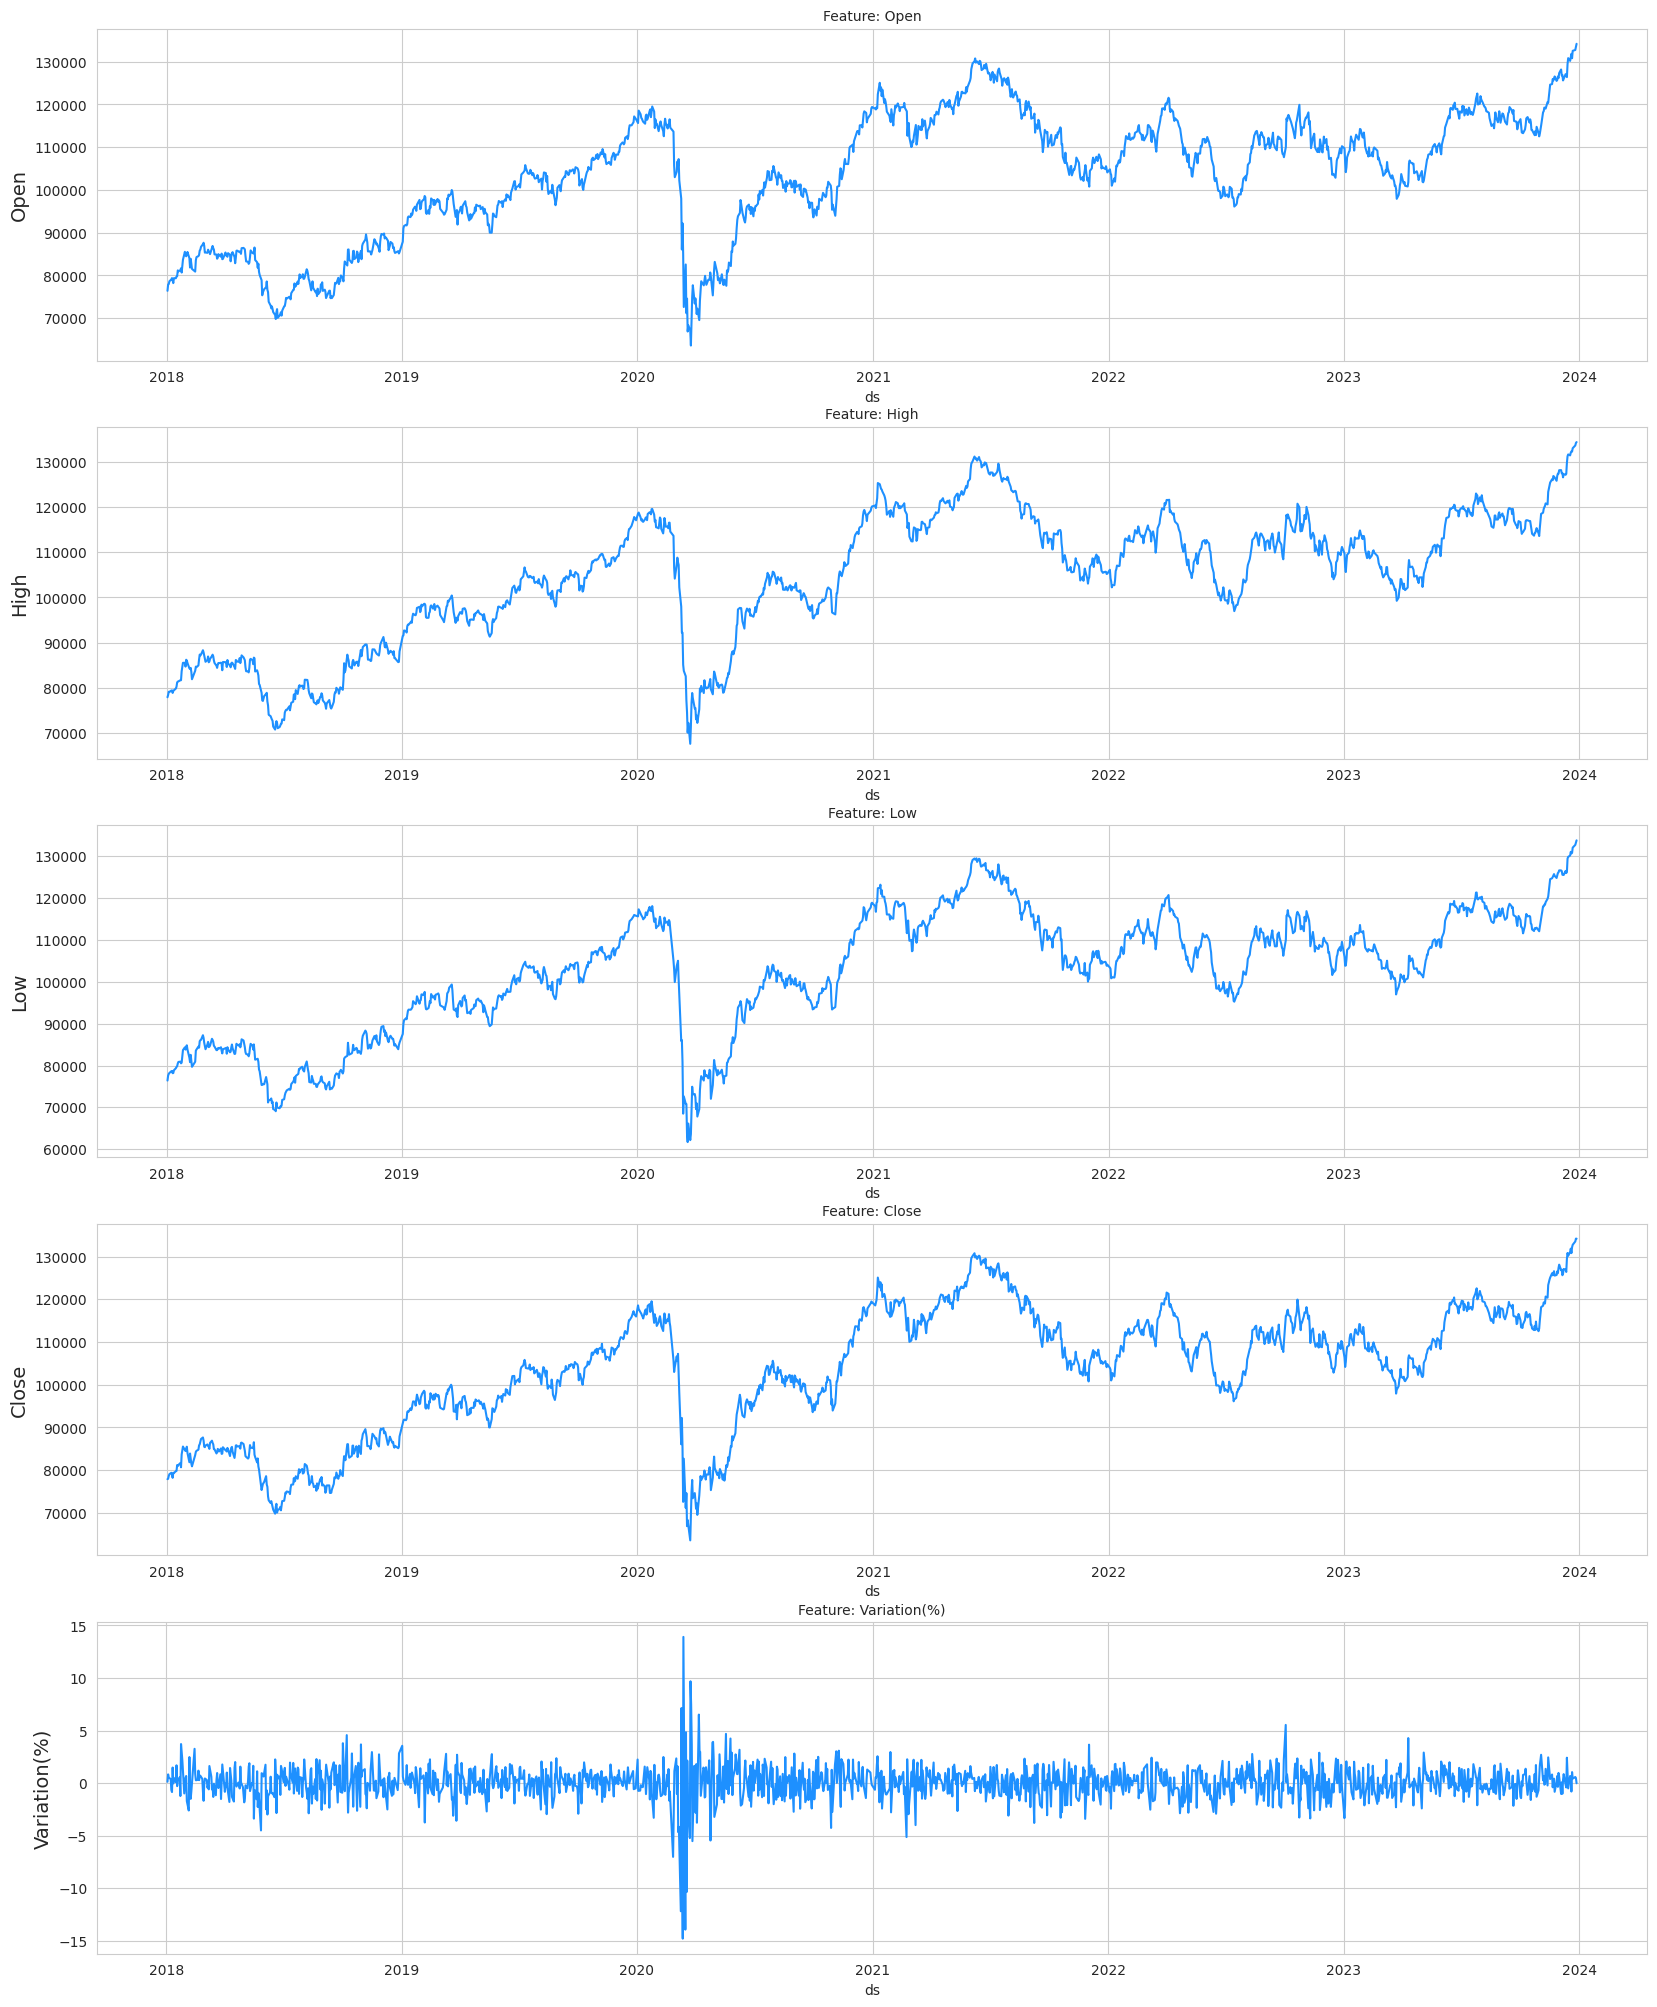

In [284]:
#Plotando cada feature.

f, ax = plt.subplots(nrows=5, ncols=1, figsize=(20,25))

for i, column in enumerate(df_completo.columns):
    sns.lineplot(x=df_completo.index, y=df_completo[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=10)
    ax[i].set_ylabel(ylabel=column, fontsize=14)

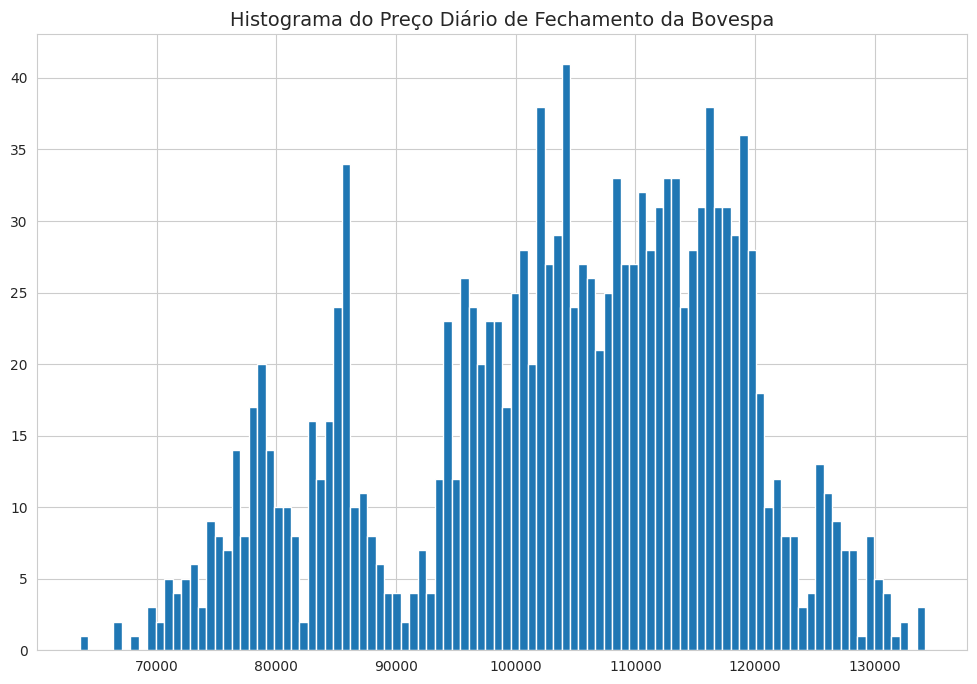

In [285]:
# Plot do histograma de valores de fechamento.
plt.figure(figsize=(12,8))
plt.hist(df_completo["Close"], bins=100)
plt.title("Histograma do Preço Diário de Fechamento da Bovespa", size = 14)
plt.show()

In [286]:
# Média do fechamento diário da cotação das ações.
media_variation = np.mean(df_completo["Variation(%)"])

# Desvio padrão do fechamento diário da cotação das ações.
desvio_variation = np.std(df_completo["Variation(%)"])

print("Média da Variation:{:.2f}%".format(media_variation))
print("Desvio Padrão da Variation:{:.2f}%".format(desvio_variation))

Média da Variation:0.05%
Desvio Padrão da Variation:1.62%


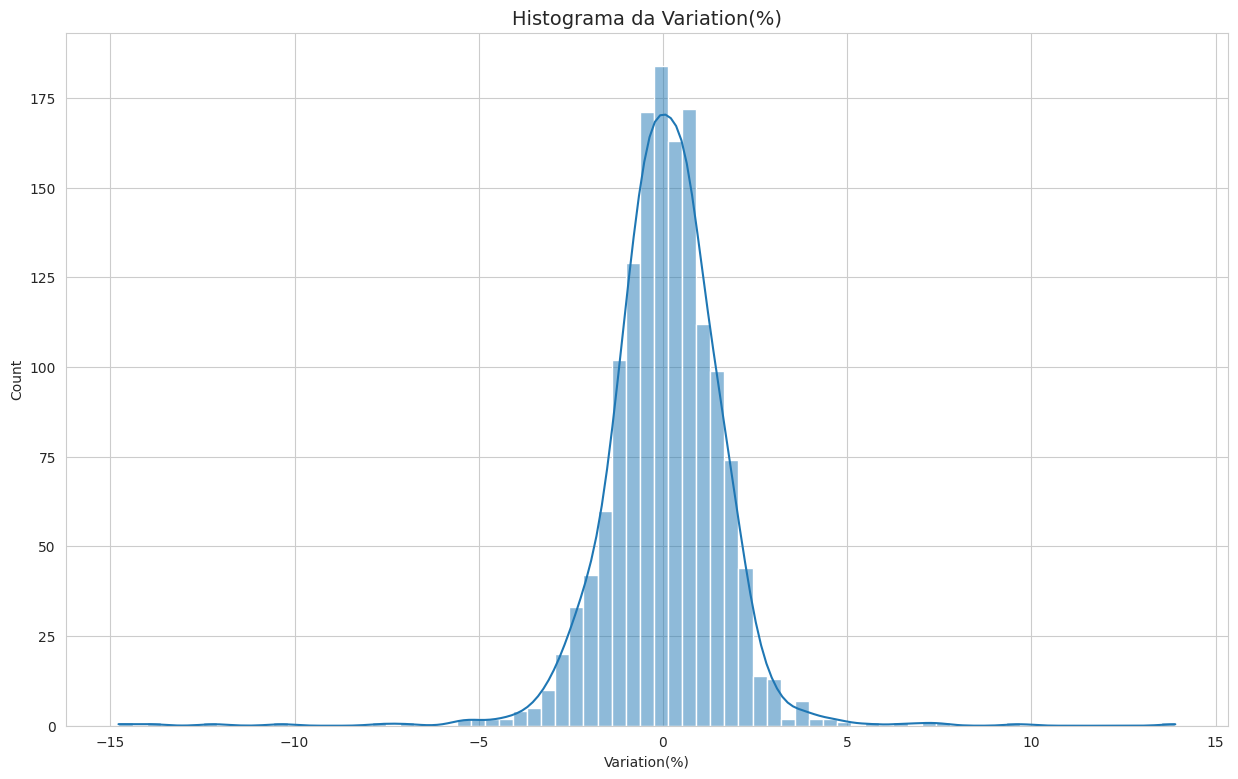

In [287]:
# Plot do histograma da variation.
sns.histplot(df_completo["Variation(%)"], bins = 75, kde=True)
plt.title("Histograma da Variation(%)", size = 14)
plt.show()

#Criando o df_bovespa

In [288]:
df_bovespa = df_completo.copy()

Dropando as colunas desnecessárias e renomeando-as.

In [289]:
df_bovespa = df_completo.drop(['Open','High','Low','Variation(%)'], axis=1)
df_bovespa.rename(columns={'Close':'y'}, inplace=True)

In [290]:
df_bovespa.head()

y
ds                 
2018-01-02 77891.00
2018-01-03 77995.00
2018-01-04 78647.00
2018-01-05 79071.00
2018-01-08 79379.00

Plotando valores de fechamento da Bovespa

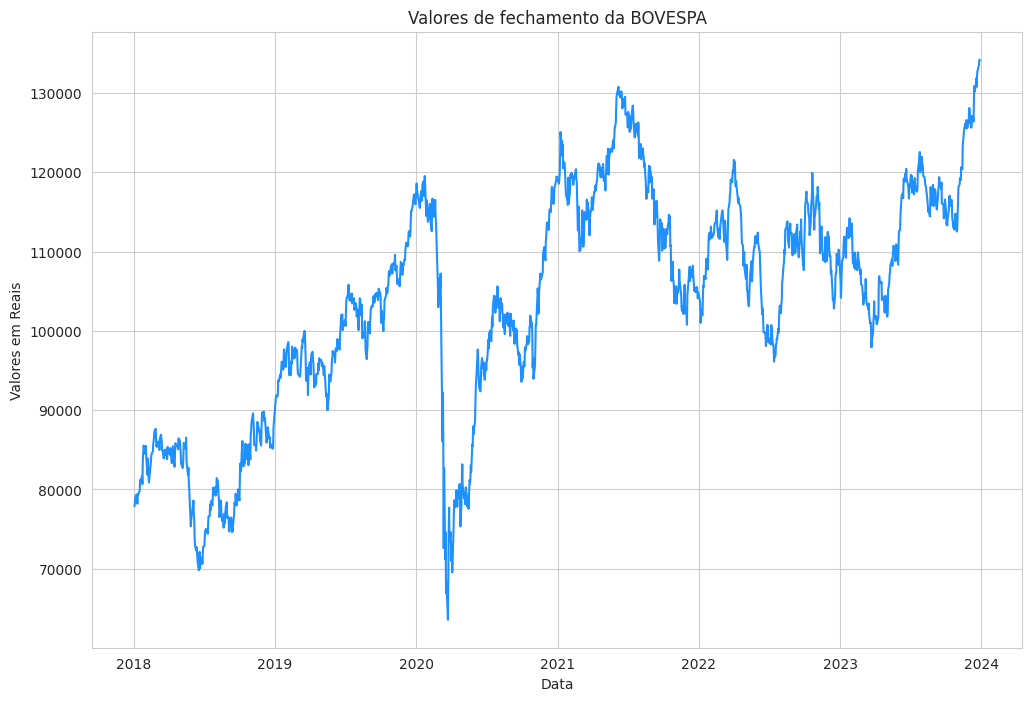

In [291]:
# visualizando os valores de fechamento da BOVESPA.

plt.figure(figsize = (12,8))
plt.plot(df_bovespa.index, df_bovespa.y, label='Bovespa', color='dodgerblue')
plt.title('Valores de fechamento da BOVESPA')
plt.xlabel('Data')
plt.ylabel('Valores em Reais')
plt.show()

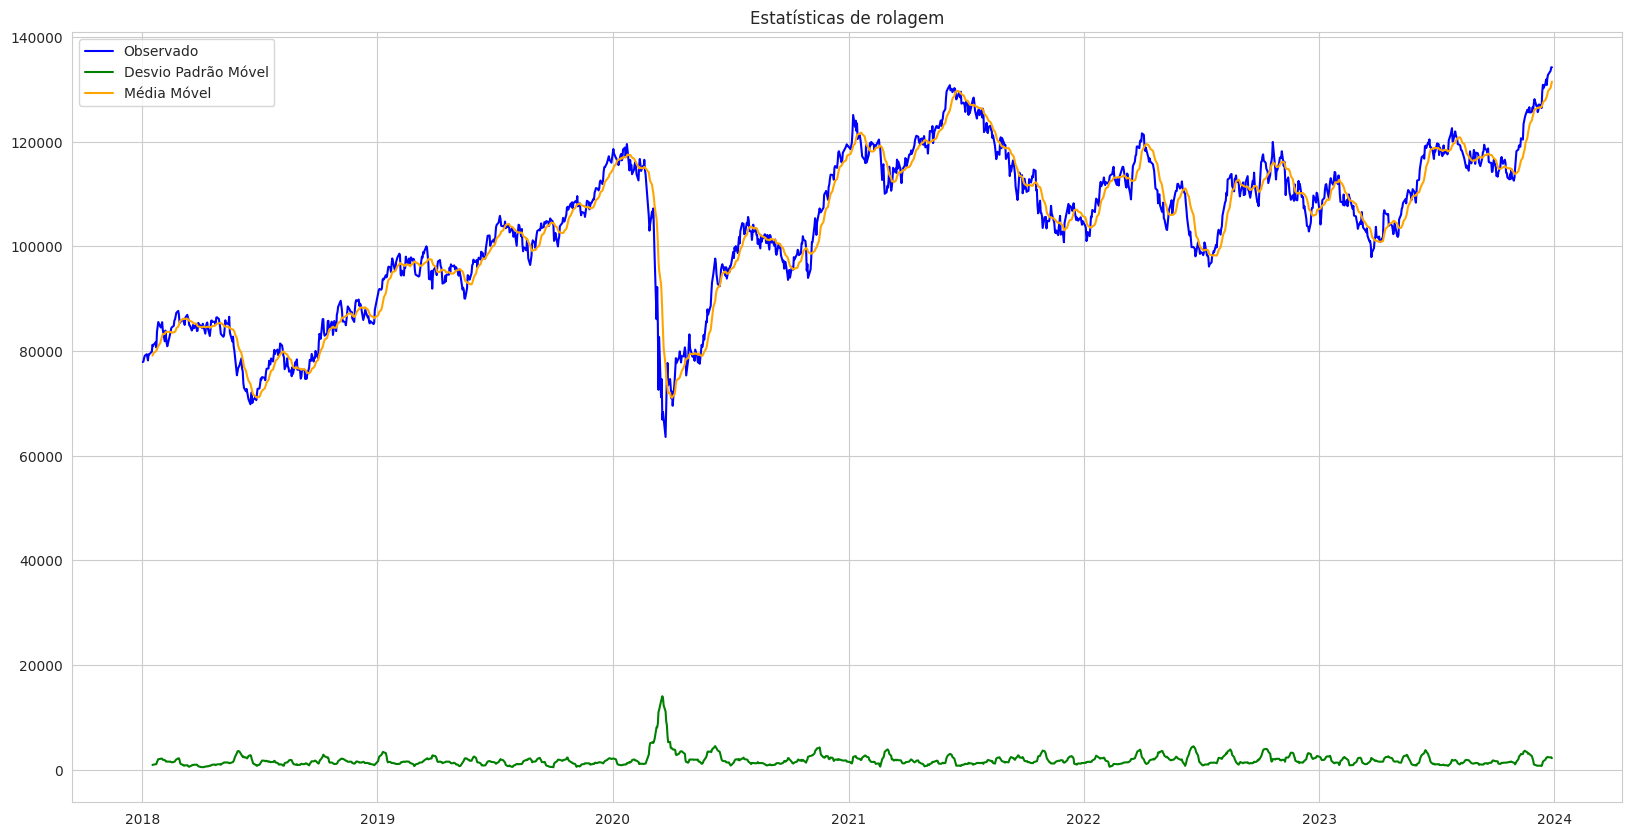

In [292]:
##Estatísticas de rolagem no período com janela de 12 dias.
plt.figure(figsize=(20,10))
desvio_movel = df_completo['Close'].rolling(window=12).std()
media_movel = df_completo['Close'].rolling(window=12).mean()
plt.plot(df_completo['Close'], color='blue', label='Observado')
plt.plot(desvio_movel, color='green',label='Desvio Padrão Móvel')
plt.plot(media_movel, color='orange', label='Média Móvel')
plt.legend(loc='best')
plt.title('Estatísticas de rolagem')
plt.show(block=False)

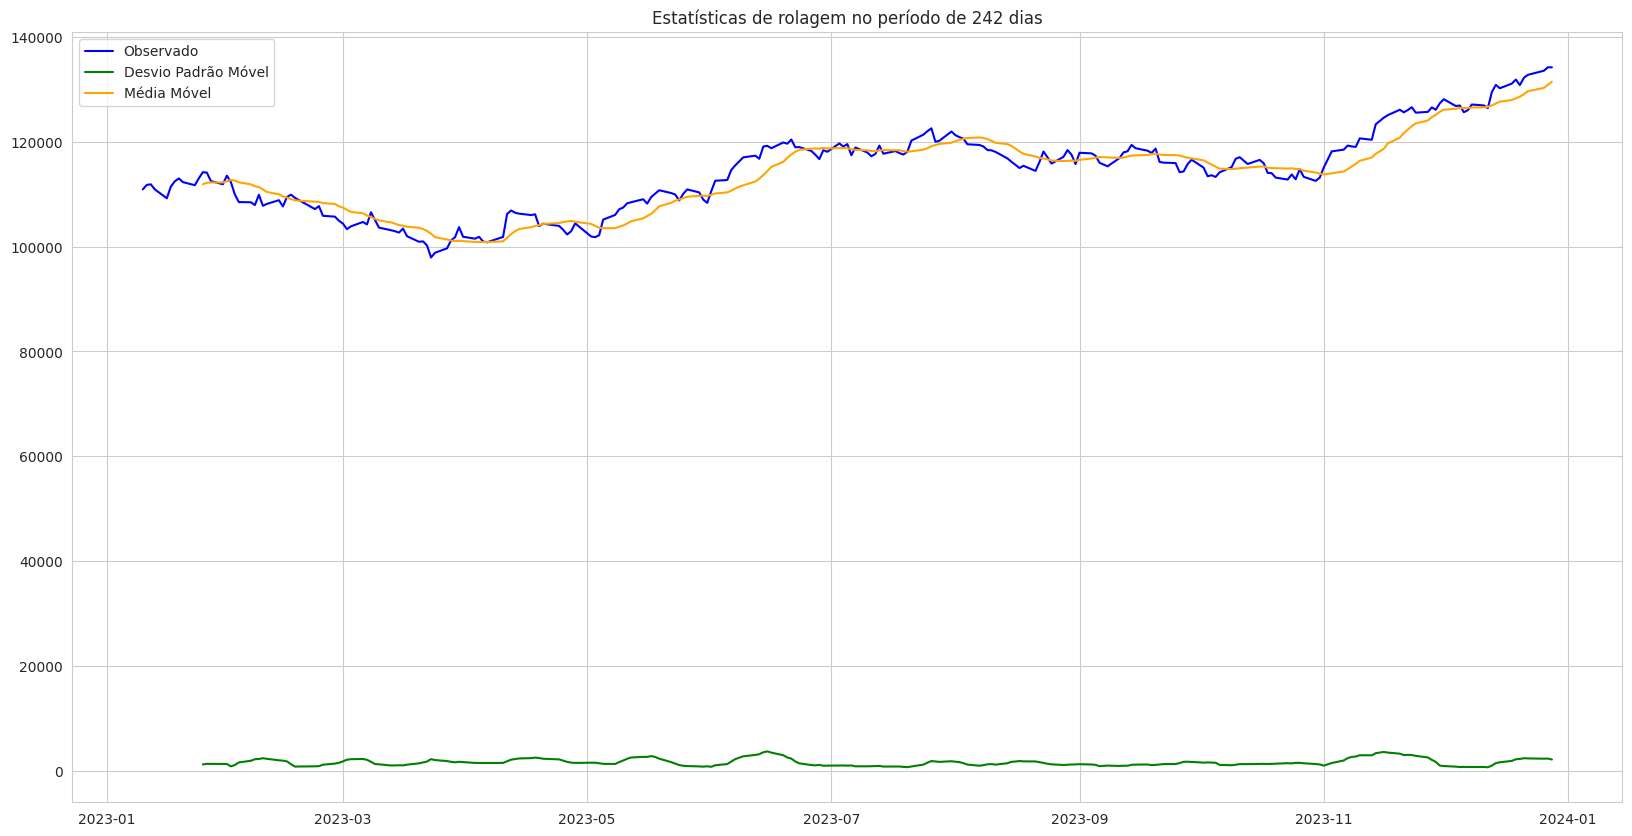

In [293]:
#Estatísticas de rolagem no período de 242 dias.
plt.figure(figsize=(20,10))
desvio_movel = df_completo['Close'][-242:].rolling(window=12).std()
media_movel = df_completo['Close'][-242:].rolling(window=12).mean()
plt.plot(df_completo['Close'][-242:], color='blue', label='Observado')
plt.plot(desvio_movel, color='green',label='Desvio Padrão Móvel')
plt.plot(media_movel, color='orange', label='Média Móvel')
plt.legend(loc='best')
plt.title('Estatísticas de rolagem no período de 242 dias')
plt.show(block=False)

Podemos observar que o desvio padrão está muito próximo de zero.

#Verificando a estacionariedade e decompondo a série temporal

In [294]:
#verificando a estacionariedade.
adftest  = adfuller(df_bovespa.y.values)

print('Teste ADF')
print(f"Teste Estatístico: {adftest[0]}")
print(f"P-value: {adftest[1]}")
print(f"Valores críticos: ")

for key, value in adftest[4].items():
  print(f"\t{key}:{value}")

Teste ADF
Teste Estatístico: -2.097403844323573
P-value: 0.24555980941571615
Valores críticos: 
	1%:-3.434785139702456
	5%:-2.863498825305098
	10%:-2.5678128583805213


 Para analisar o resultado  precisamos olhar para o p-valor que tem ser menor do que o nível de significância escolhido e o valor do teste tem que ser menor que o valor crítico para esse mesmo nível de significância. E podemos observar que a série é não estacionária.

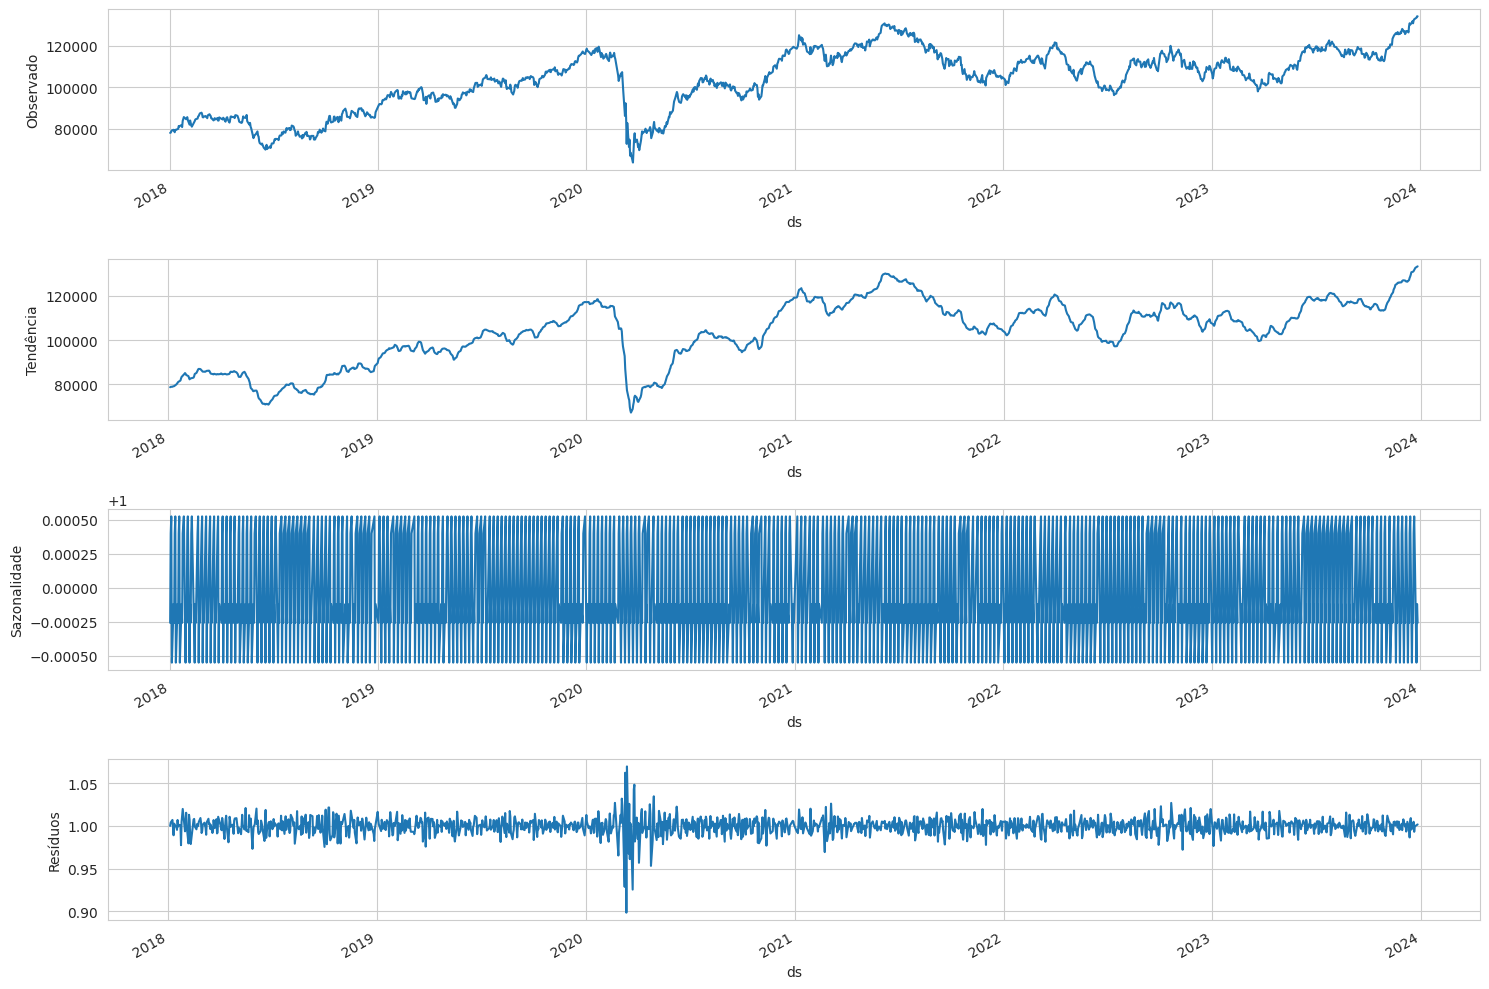

In [295]:
resultados = seasonal_decompose(df_bovespa, model='multiplicative',period=5)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize =(15,10))

resultados.observed.plot(ax = ax1, ylabel='Observado')
resultados.trend.plot( ax = ax2, ylabel='Tendência')
resultados.seasonal.plot( ax = ax3, ylabel='Sazonalidade')
resultados.resid.plot(ax = ax4, ylabel='Resíduos')

plt.tight_layout()
plt.show()

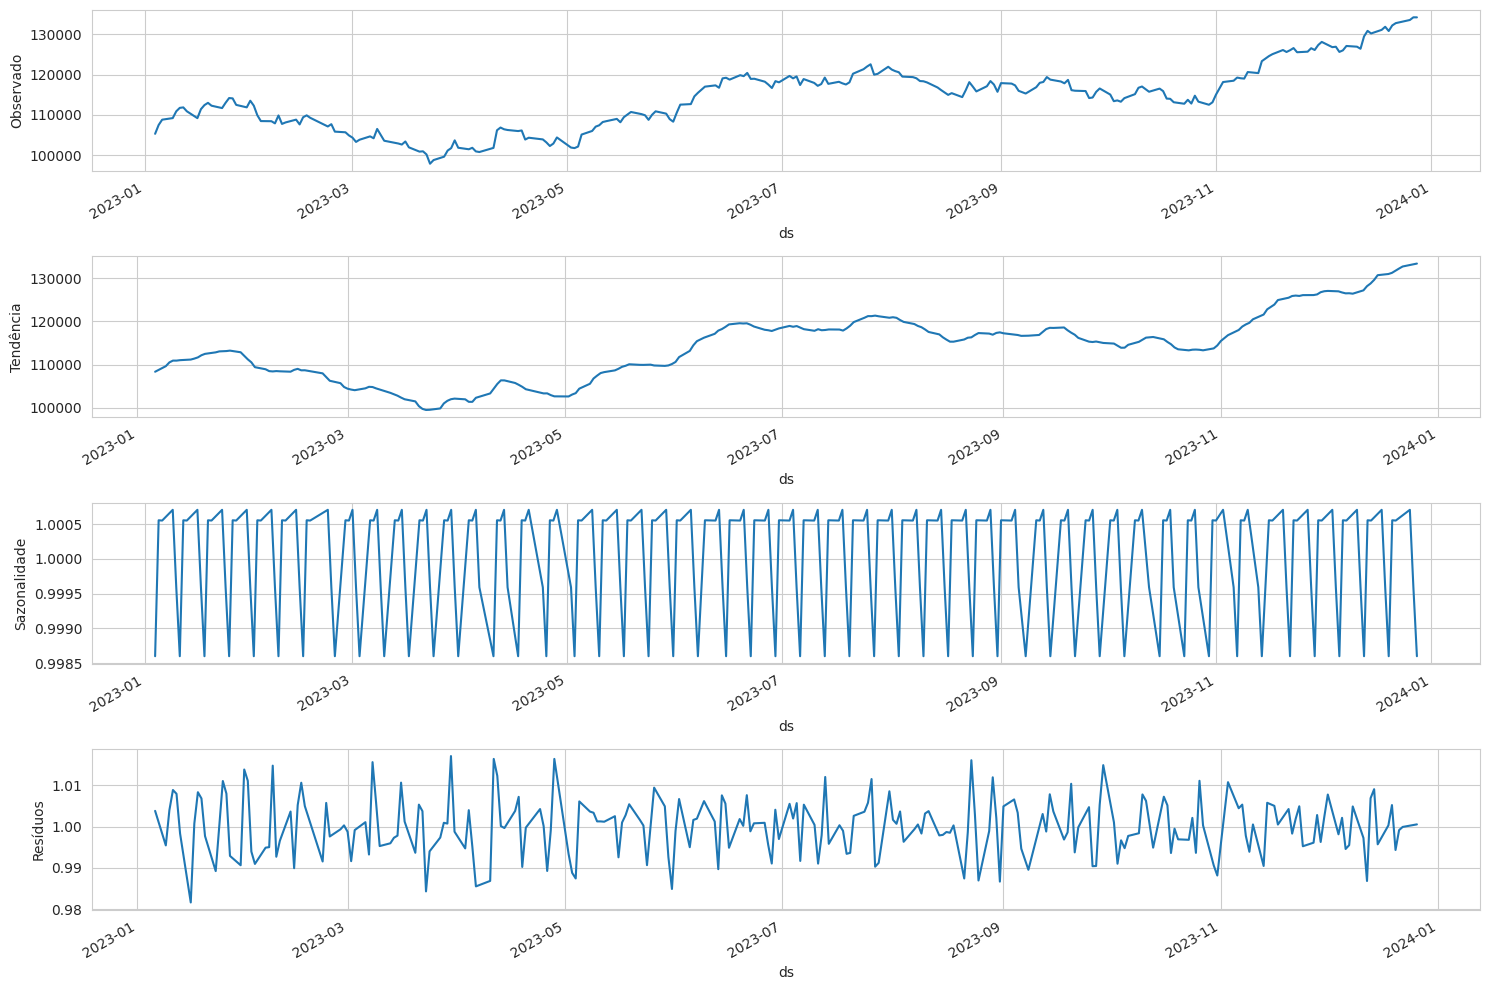

In [296]:
#visualizando os dados do ano de 2023.
resultados = seasonal_decompose(df_bovespa[df_bovespa.index > '2023-01-03'], model='multiplicative',period=5)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize =(15,10))

resultados.observed.plot(ax = ax1, ylabel='Observado')
resultados.trend.plot( ax = ax2, ylabel='Tendência')
resultados.seasonal.plot( ax = ax3, ylabel='Sazonalidade')
resultados.resid.plot(ax = ax4, ylabel='Resíduos')

plt.tight_layout()
plt.show()

In [297]:
df_bovespa

y
ds                  
2018-01-02  77891.00
2018-01-03  77995.00
2018-01-04  78647.00
2018-01-05  79071.00
2018-01-08  79379.00
...              ...
2023-12-21 132182.00
2023-12-22 132753.00
2023-12-26 133533.00
2023-12-27 134194.00
2023-12-28 134185.00

[1486 rows x 1 columns]

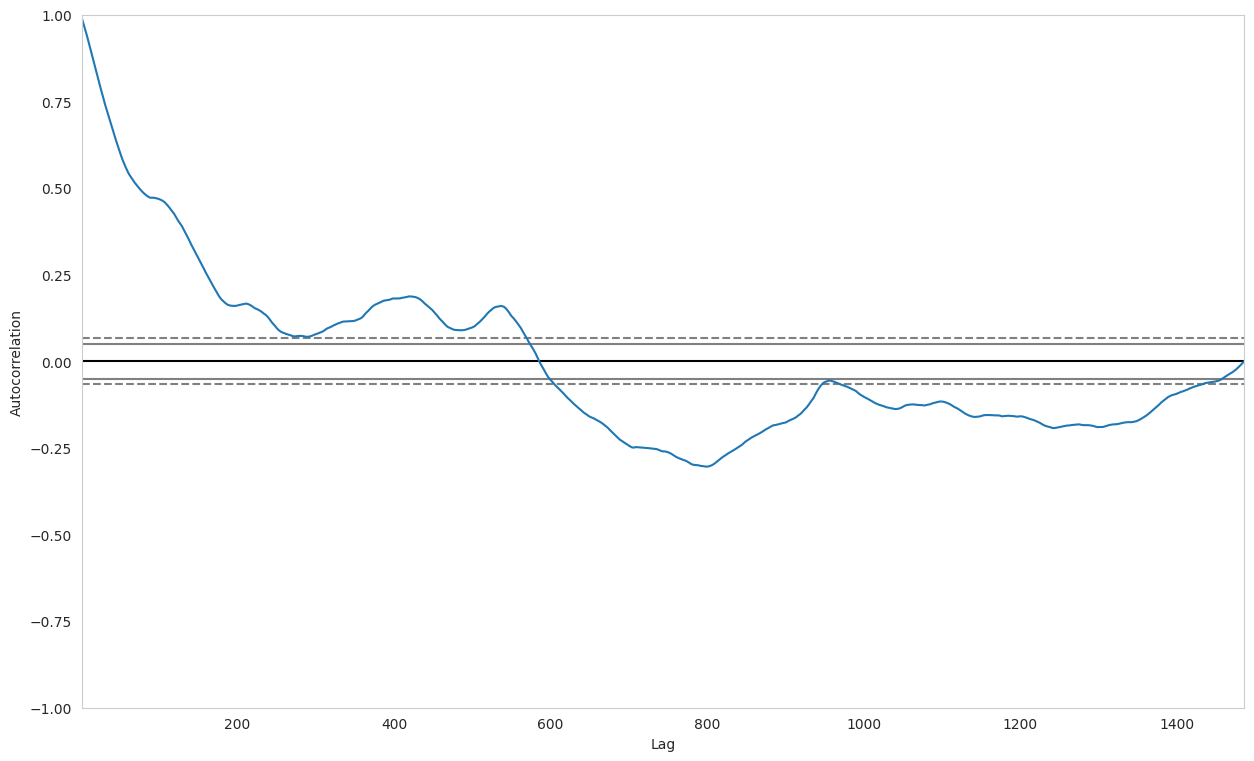

In [298]:
autocorrelation_plot(df_bovespa['y'])
plt.show()

O gráfico da autocorrelaçao nos fornece informações sobre a aleatoriedade dos dados.

# 1 - Média Móvel

É um método que utiliza a média de registros observados  para prever data futura.

Vamos analisar a média móvel com a finalidade de suavizar o pico. Novas séries são construídas com a média dos valores dos 10, 20 e 50 dias.

In [299]:
df_bovespa_ma = df_bovespa.copy()

In [300]:
media_movel_day = [10, 20, 50]

for m in media_movel_day:
    coluna  = f"MA for {m} days"
    df_bovespa_ma[coluna] = df_bovespa['y'].rolling(m).mean()

In [301]:
df_bovespa_ma

y  MA for 10 days  MA for 20 days  MA for 50 days
ds                                                                  
2018-01-02  77891.00             NaN             NaN             NaN
2018-01-03  77995.00             NaN             NaN             NaN
2018-01-04  78647.00             NaN             NaN             NaN
2018-01-05  79071.00             NaN             NaN             NaN
2018-01-08  79379.00             NaN             NaN             NaN
...              ...             ...             ...             ...
2023-12-21 132182.00       129683.80       128073.75       122103.58
2023-12-22 132753.00       130249.70       128434.30       122423.90
2023-12-26 133533.00       130911.40       128826.80       122753.54
2023-12-27 134194.00       131690.50       129209.60       123122.34
2023-12-28 134185.00       132162.50       129613.80       123475.36

[1486 rows x 4 columns]

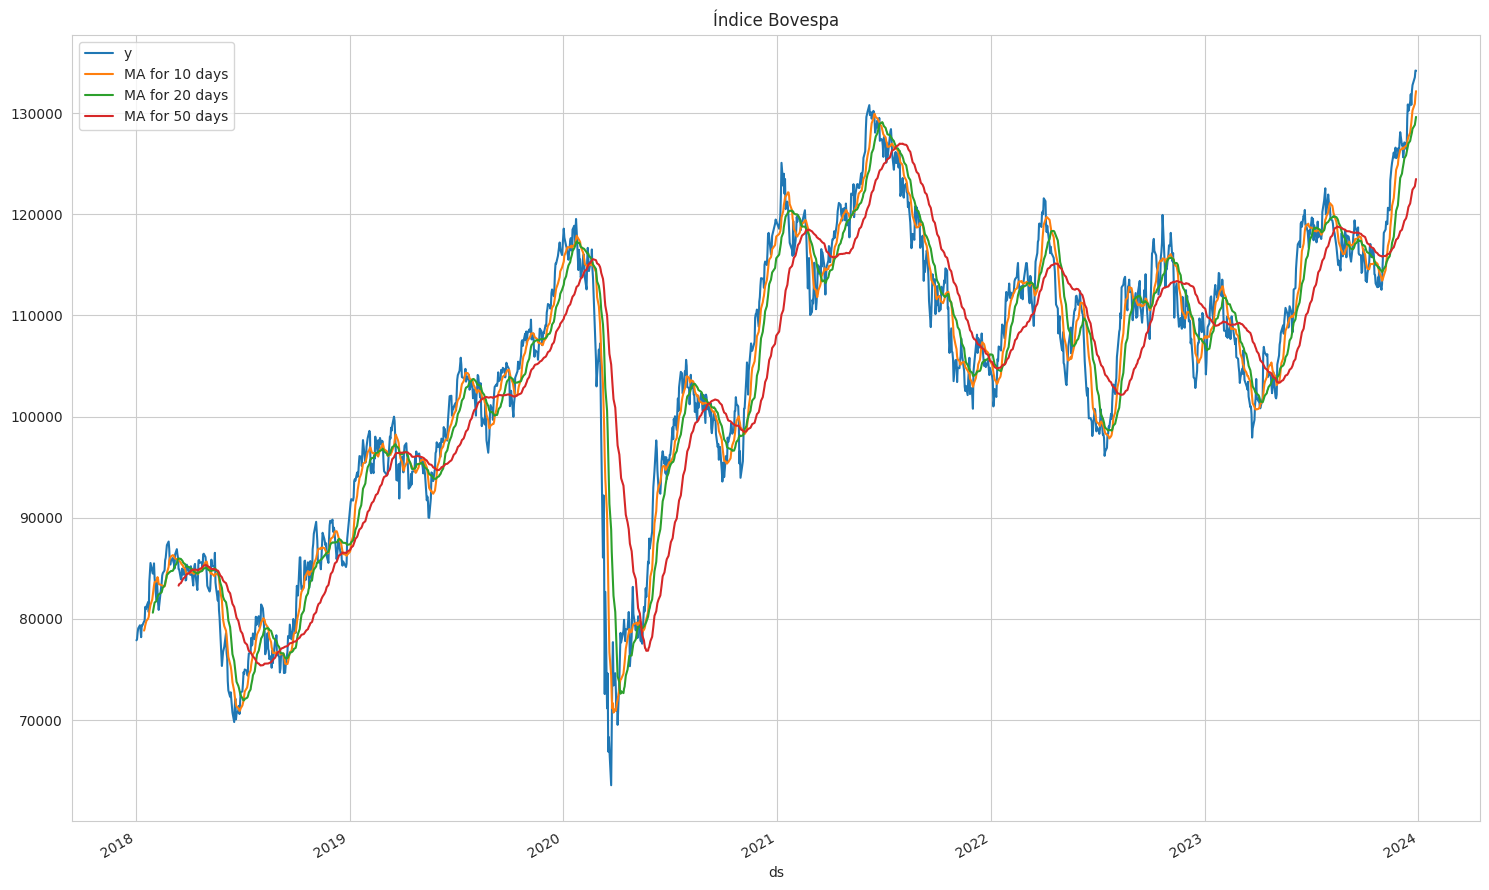

In [302]:
#plotando o gráfico com a média móvel nas janelas de 10, 20 e 50 dias.
df_bovespa_ma[['y', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.title('Índice Bovespa')
plt.tight_layout()
plt.show()

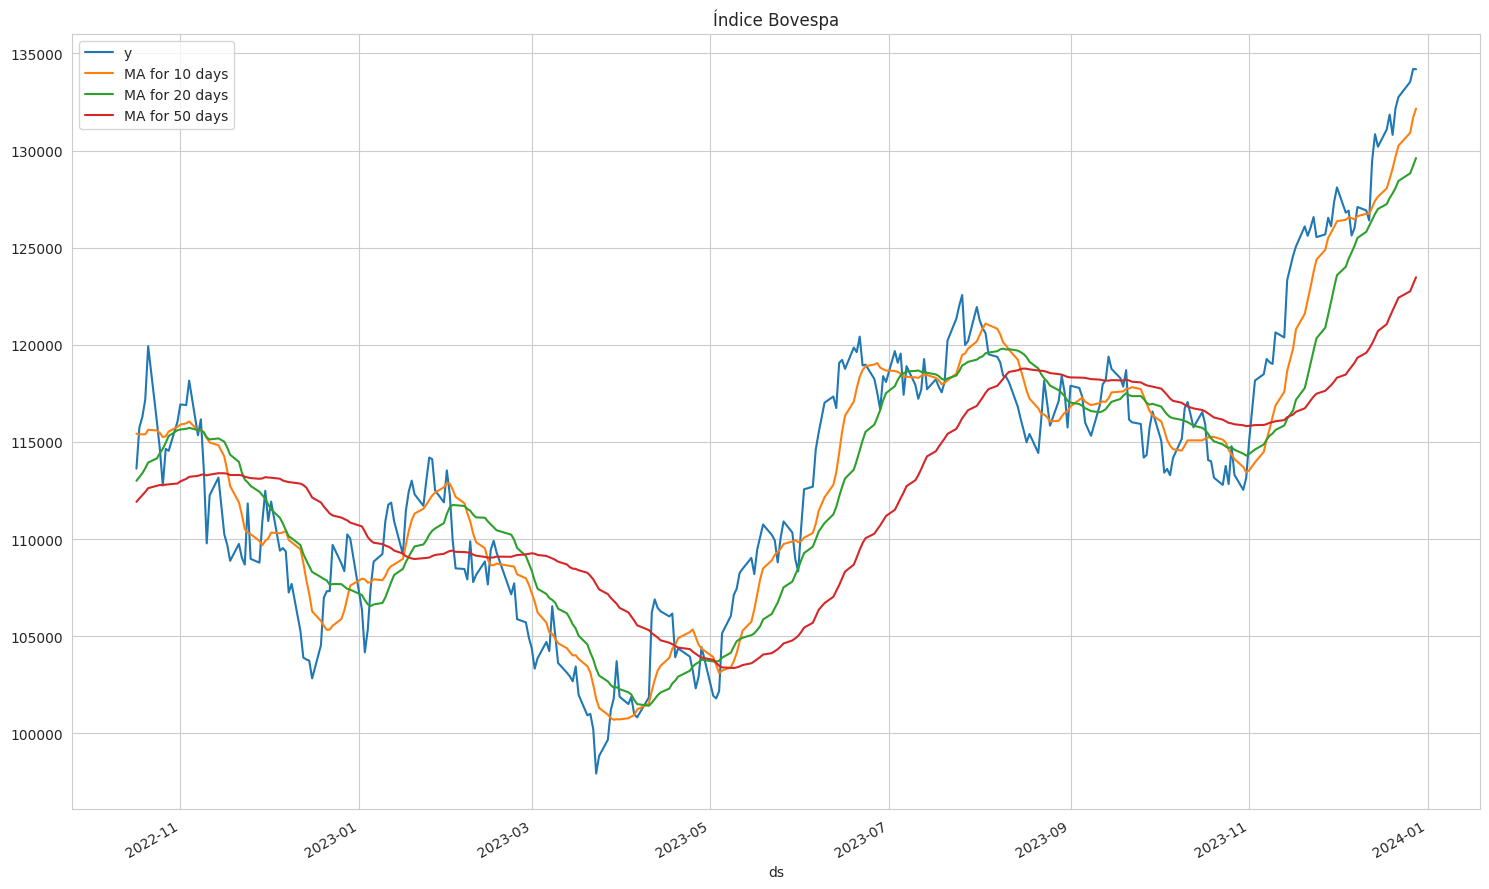

In [303]:
#visualizando os últimos 300 dias.
df_bovespa_ma[['y', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']][-300:].plot()
plt.title('Índice Bovespa')
plt.tight_layout()
plt.show()

O modelo média móvel assume que foi removida a tendência e a sazonalidade da série temporal.

In [304]:
#fazendo a predição para 10 dias
df_bovespa_ma['MA_window_10_forward_10'] = np.NaN

In [305]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]

In [306]:
df_bovespa_ma.tail(5)

y  MA for 10 days  MA for 20 days  MA for 50 days  \
ds                                                                     
2023-12-21 132182.00       129683.80       128073.75       122103.58   
2023-12-22 132753.00       130249.70       128434.30       122423.90   
2023-12-26 133533.00       130911.40       128826.80       122753.54   
2023-12-27 134194.00       131690.50       129209.60       123122.34   
2023-12-28 134185.00       132162.50       129613.80       123475.36   

            MA_window_10_forward_10  
ds                                   
2023-12-21                      NaN  
2023-12-22                      NaN  
2023-12-26                      NaN  
2023-12-27                      NaN  
2023-12-28                      NaN

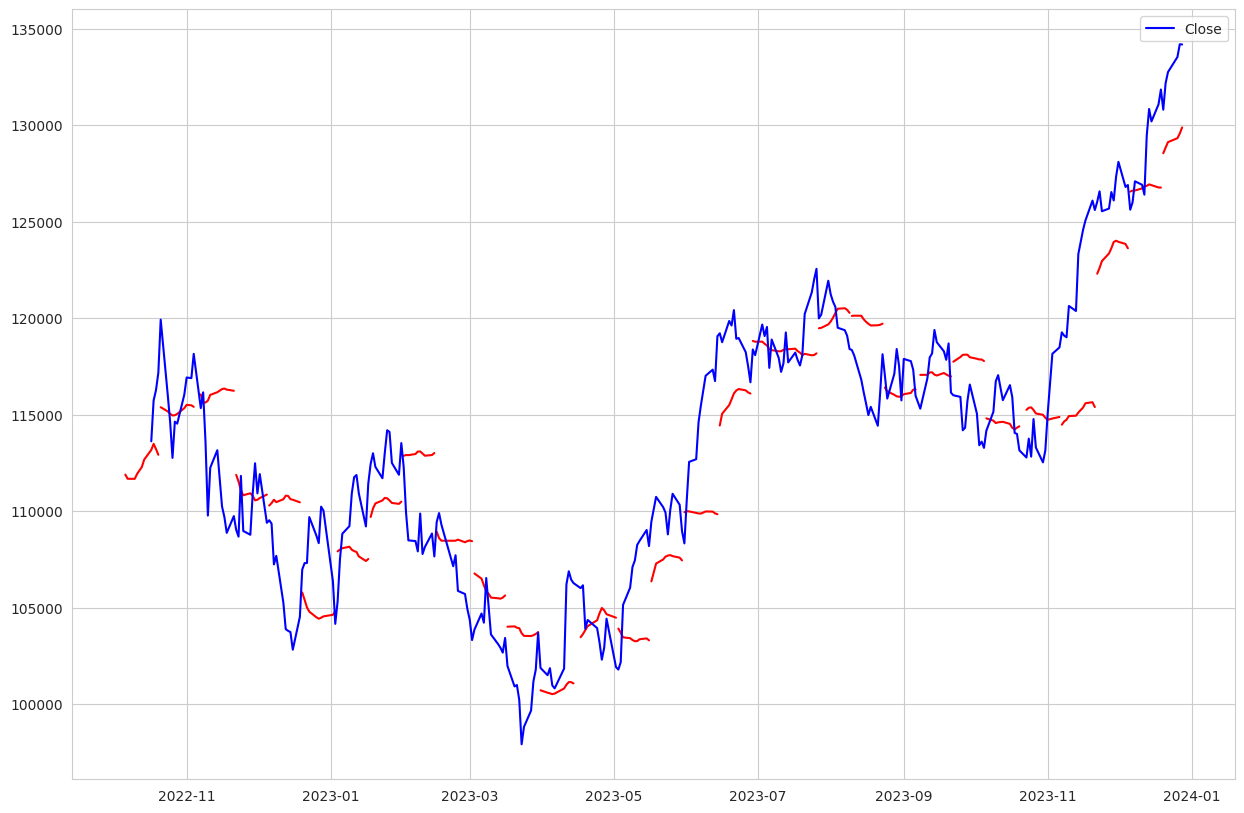

In [307]:
janela = 10
dias_previstos = 10


for index in range(janela, len(df_bovespa_ma), dias_previstos):
    for i in range(0, dias_previstos):
        if index + i >= len(df_bovespa_ma):
            break
        window_close = make_window(janela - i, index + i - janela)
        window_MA = make_window(i, index)
        mean = pd.concat([df_bovespa_ma['y'].iloc[window_close], df_bovespa_ma['MA_window_10_forward_10'].iloc[window_MA]]).mean(axis=0)
        df_bovespa_ma.iat[index + i, df_bovespa_ma.columns.get_loc('MA_window_10_forward_10')] = mean


#plotando o resultado da previsão com a média móvel.

plt.figure(figsize = (15,10))

size = len(df_bovespa_ma)-300 - (len(df_bovespa_ma)-300)%dias_previstos

for index in range(size, len(df_bovespa_ma), dias_previstos):
    plt.plot(df_bovespa_ma['MA_window_10_forward_10'][index:index+dias_previstos], color='r')

plt.plot(df_bovespa_ma['y'][-300:], color='b', label='Close')
plt.legend(loc='best')
plt.show()

A média móvel foi executada com base nos dez dias anteriores a fim de prever os 10 dias posteriores, contudo o modelo é muito simples e não perfoma bem.

#2 - Prophet


https://www.analyticsvidhya.com/blog/2022/07/predict-your-portfolios-stock-price-action-using-facebooks-prophet/

###modelo prophet 1 - 385 dias - mape 4.11

In [308]:
df_prophet = df_bovespa.reset_index('ds')
df_prophet

ds         y
0    2018-01-02  77891.00
1    2018-01-03  77995.00
2    2018-01-04  78647.00
3    2018-01-05  79071.00
4    2018-01-08  79379.00
...         ...       ...
1481 2023-12-21 132182.00
1482 2023-12-22 132753.00
1483 2023-12-26 133533.00
1484 2023-12-27 134194.00
1485 2023-12-28 134185.00

[1486 rows x 2 columns]

In [309]:
#visualização com plotly do valores de fechamento.
fig = px.line(df_prophet, x='ds', y='y')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [310]:
train_size = int(0.85 * len(df))
test_size = len(df_prophet) - train_size

train_data = df_prophet.iloc[:train_size, :]
test_data = df_prophet.iloc[train_size:, :]

x_train, y_train = pd.DataFrame(df_prophet.iloc[:train_size, 0]), pd.DataFrame(df_prophet.iloc[:train_size, 1])
x_test, y_test = pd.DataFrame(df_prophet.iloc[train_size:, 0]), pd.DataFrame(df_prophet.iloc[train_size:, 1])

print(len(train_data), len(x_test))

1263 223


In [311]:
#treinando o modelo, criando o dataframe e fazendo a predição.
model = Prophet(daily_seasonality=True)
model.add_country_holidays(country_name='BR')
model.fit(train_data)

#determinando o período de dias para previsão.
future = model.make_future_dataframe(periods=385, freq='B')
forecast = model.predict(future)
forecast.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/af4qj5hk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/qd7locyo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70751', 'data', 'file=/tmp/tmpw8zhb_nh/af4qj5hk.json', 'init=/tmp/tmpw8zhb_nh/qd7locyo.json', 'output', 'file=/tmp/tmpw8zhb_nh/prophet_modelodukjrfb/prophet_model-20240127225854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:58:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:58:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-01-02 77761.89    75890.56    88765.42     77761.89     77761.89   
1 2018-01-03 77762.31    75903.77    89259.31     77762.31     77762.31   
2 2018-01-04 77762.73    75617.76    89654.46     77762.73     77762.73   
3 2018-01-05 77763.15    76478.57    89334.91     77763.15     77763.15   
4 2018-01-08 77764.41    76481.40    90169.28     77764.41     77764.41   

   Confraternização Universal  Confraternização Universal_lower  \
0                        0.00                              0.00   
1                        0.00                              0.00   
2                        0.00                              0.00   
3                        0.00                              0.00   
4                        0.00                              0.00   

   Confraternização Universal_upper  Dia do Trabalhador  ...  weekly  \
0                              0.00                0.00  ...   93.91   
1                              0.00                0.00  ...  111.56   
2                              0.00                0.00  ...  146.09   
3                              0.00                0.00  ...  163.51   
4                              0.00                0.00  ...  100.79   

   weekly_lower  weekly_upper  yearly  yearly_lower  yearly_upper  \
0         93.91         93.91 1892.53       1892.53       1892.53   
1        111.56        111.56 2074.61       2074.61       2074.61   
2        146.09        146.09 2263.75       2263.75       2263.75   
3        163.51        163.51 2458.10       2458.10       2458.10   
4        100.79        100.79 3053.74       3053.74       3053.74   

   multiplicative_terms  multiplicative_terms_lower  \
0                  0.00                        0.00   
1                  0.00                        0.00   
2                  0.00                        0.00   
3                  0.00                        0.00   
4                  0.00                        0.00   

   multiplicative_terms_upper     yhat  
0                        0.00 82211.78  
1                        0.00 82411.93  
2                        0.00 82636.01  
3                        0.00 82848.20  
4                        0.00 83382.38  

[5 rows x 52 columns]

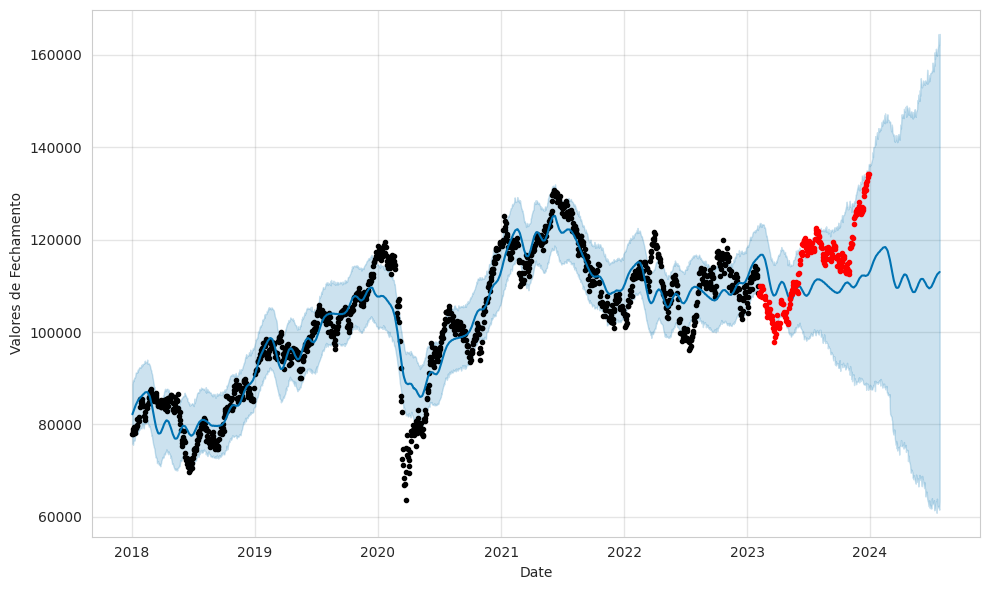

In [312]:
# previsões do modelo treinado.

model.plot(forecast, xlabel = 'Date', ylabel = 'Valores de Fechamento')
plt.plot(test_data['ds'], test_data['y'], '.r')  #valores de teste
plt.show()


In [313]:
plot_plotly(model,forecast)

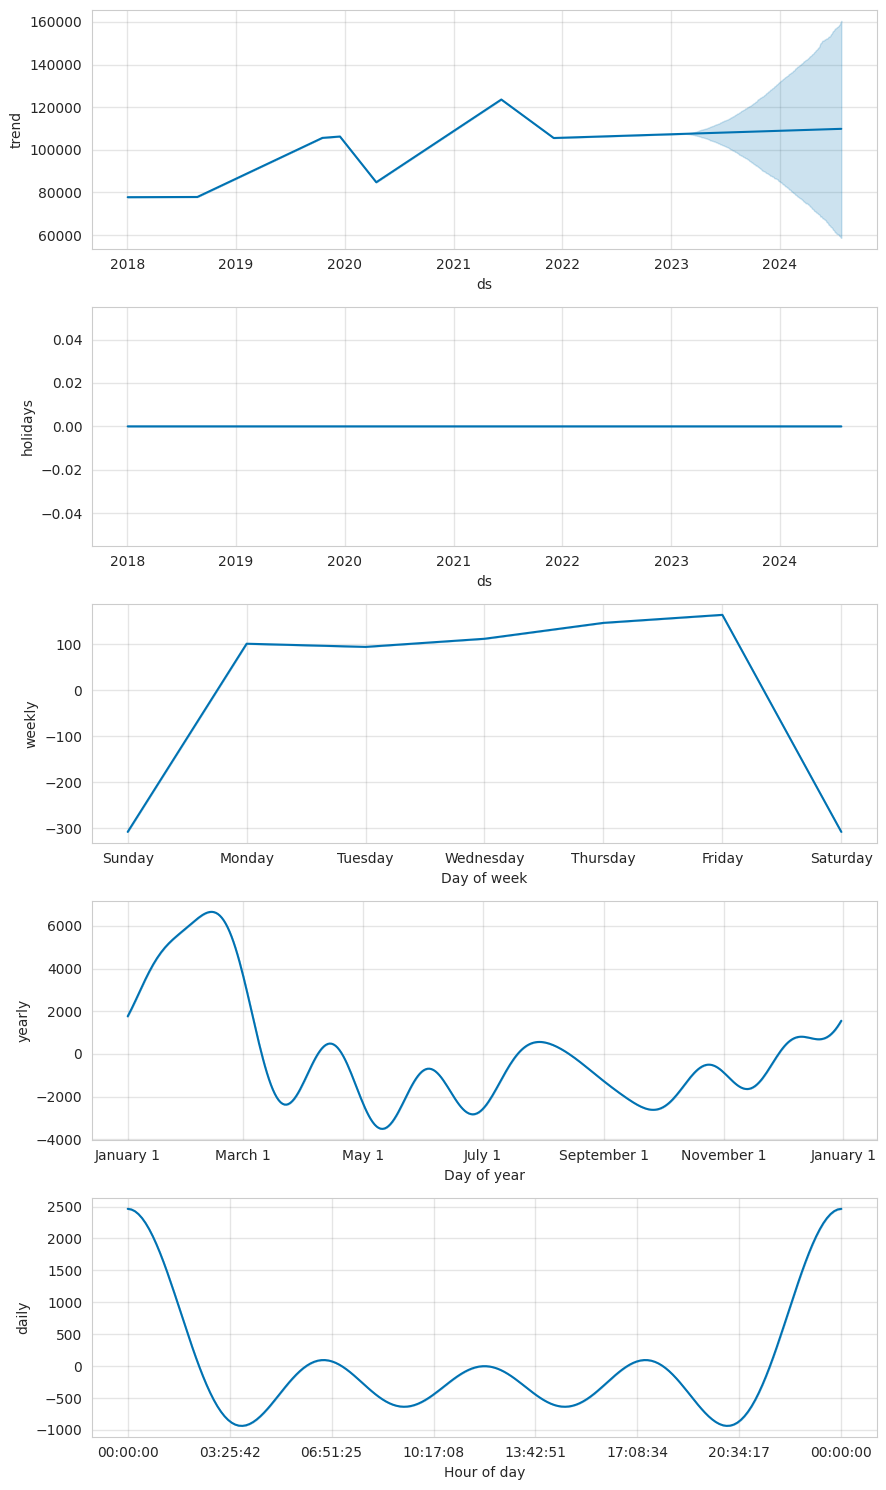

In [314]:
# verificando os componentes.
fig = model.plot_components(forecast)

Nos componentes podemos observar a tendência, o comportamento dos dados nos dias da semana e meses do ano.

In [315]:
previsao = forecast[['ds', 'yhat']]
valores_reais = train_data[['ds', 'y']]

# Mesclar os dataframes nas colunas 'ds' para comparar previsões e valores reais.
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados.
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE.
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 4.11%


O critério para essa divisão no cross validation será definido através de alguns parâmetros:

1. initial-  define a porção inicial de dados que serão usados para o treinamento

2.  horizon - que é o tamanho da previsão que será feita

3. period -é o periodo que definimos de quanto em quanto tempo definimos um novo horizonte para prever.

In [316]:
df_cv = cross_validation(model, initial='730 days', period='90 days', horizon = '180 days')

INFO:prophet:Making 11 forecasts with cutoffs between 2020-02-19 00:00:00 and 2022-08-07 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/f933o9or.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/ocbylvwv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44126', 'data', 'file=/tmp/tmpw8zhb_nh/f933o9or.json', 'init=/tmp/tmpw8zhb_nh/ocbylvwv.json', 'output', 'file=/tmp/tmpw8zhb_nh/prophet_model8cum4vw9/prophet_model-20240127225905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:59:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/oxjhn21l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/qpliua2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

A função cross_validation divide os dados em diversos grupos e consegue treinar e validar o modelo diversas vezes.

In [317]:
df_cv['cutoff'].nunique()

11

In [318]:
cutoff = df_cv['cutoff'].unique()[10]
df_cv_cut = df_cv[df_cv['cutoff'].values == cutoff]

Text(0.5, 0, 'ds')

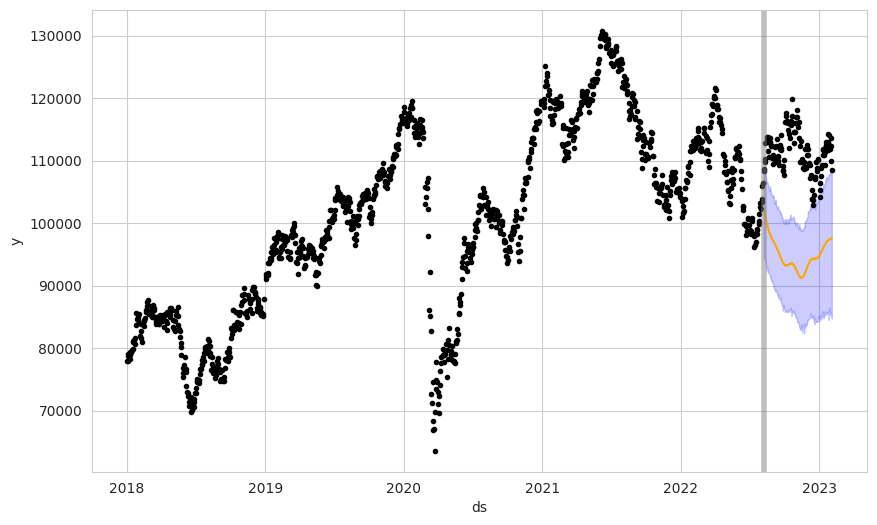

In [319]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(model.history['ds'].values, model.history['y'], 'k.')
ax.plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', c='orange')
ax.fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'],
                df_cv_cut['yhat_upper'], color='blue',
                alpha=0.2)
ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')


Em cinza temos o cuttoff.

A região em azul com intervalo de confiança e o trecho que foi usado pra teste.

In [320]:
df_p = performance_metrics(df_cv_cut)
df_p

horizon          mse     rmse      mae  mape  mdape  smape  coverage
0    16 days 136526634.61 11684.46 11346.11  0.10   0.11   0.11      0.17
1    17 days 150848287.15 12282.03 12025.82  0.11   0.11   0.11      0.08
2    18 days 166700672.33 12911.26 12733.84  0.11   0.12   0.12      0.00
3    19 days 177424964.52 13320.10 13199.06  0.12   0.12   0.12      0.00
4    22 days 189703280.79 13773.28 13724.76  0.12   0.12   0.13      0.00
..       ...          ...      ...      ...   ...    ...    ...       ...
109 176 days 233065582.64 15266.49 15226.76  0.14   0.14   0.15      0.00
110 177 days 236807420.34 15388.55 15348.57  0.14   0.14   0.15      0.00
111 178 days 241636261.68 15544.65 15524.52  0.14   0.14   0.15      0.00
112 179 days 236353035.88 15373.78 15330.24  0.14   0.14   0.15      0.00
113 180 days 226000353.63 15033.31 14940.23  0.13   0.14   0.14      0.00

[114 rows x 8 columns]

    MSE: Média do erro ao quadrado

    RMSE: Raiz quadrada da métrica MSE

    MAE: Média do erro absoluto

    MAPE: Média do erro absoluto percentual

    MDAPE: Mediana do erro absoluto percentual

A MSE é a média obtida após calcular a diferença do valor real pelo valor previsto, elevando ao quadrado e realizando a média.

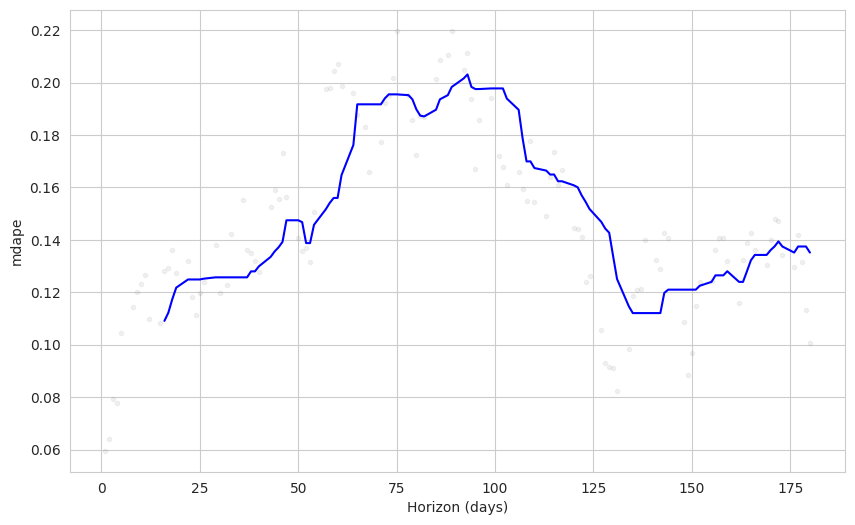

In [321]:
# Média do erro ao quadrado.
plot_cross_validation_metric(df_cv_cut, metric='mdape')
plt.show()

Quanto menos disperso melhor está sendo o resultado.

##modelo prophet 2 -180 dias - com cross validation

In [322]:
df_prophet.shape

(1486, 2)

In [323]:
# criando um novo dataset para avaliar o modelo com cross_validation.
df_cv = cross_validation(model, horizon = '180 days')
df_cv.head()

INFO:prophet:Making 13 forecasts with cutoffs between 2019-08-23 00:00:00 and 2022-08-07 00:00:00


  0%|          | 0/13 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/4a0gez5s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/nm8n5o66.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72126', 'data', 'file=/tmp/tmpw8zhb_nh/4a0gez5s.json', 'init=/tmp/tmpw8zhb_nh/nm8n5o66.json', 'output', 'file=/tmp/tmpw8zhb_nh/prophet_modelbu8aosjn/prophet_model-20240127225922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:59:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/m9di_7a7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/qja22blp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

ds     yhat  yhat_lower  yhat_upper         y     cutoff
0 2019-08-26 99051.22    96979.59   100909.86  96430.00 2019-08-23
1 2019-08-27 99086.17    97150.06   100923.20  97276.00 2019-08-23
2 2019-08-28 98796.10    96894.45   100567.48  98194.00 2019-08-23
3 2019-08-29 98597.81    96703.76   100488.59 100524.00 2019-08-23
4 2019-08-30 98418.21    96544.50   100321.56 101135.00 2019-08-23

In [324]:
# extraindo métricas de desempenho.
df_p = performance_metrics(df_cv)
df_p.head()

horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 18 days  93766828.81  9683.33 7565.02  0.07   0.05   0.07      0.42
1 19 days 103017090.21 10149.73 7958.13  0.08   0.05   0.08      0.39
2 20 days 116021165.05 10771.31 8382.43  0.08   0.06   0.08      0.37
3 21 days 132512515.58 11511.41 8931.57  0.09   0.06   0.09      0.34
4 22 days 155174115.09 12456.89 9623.60  0.09   0.06   0.10      0.32

##modelo prophet 3 - 90 dias - mape 4.11

In [325]:
df_prophet

ds         y
0    2018-01-02  77891.00
1    2018-01-03  77995.00
2    2018-01-04  78647.00
3    2018-01-05  79071.00
4    2018-01-08  79379.00
...         ...       ...
1481 2023-12-21 132182.00
1482 2023-12-22 132753.00
1483 2023-12-26 133533.00
1484 2023-12-27 134194.00
1485 2023-12-28 134185.00

[1486 rows x 2 columns]

In [326]:
#treinando o modelo, criando o dataframe de 365 dias e fazendo a predição.
model2 = Prophet(daily_seasonality=True)
model2.add_country_holidays(country_name='BR')
model2.fit(train_data)

future2 = model2.make_future_dataframe(90, freq='B')
forecast2 = model2.predict(future2)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/uvspc092.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/_2g5mccc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46486', 'data', 'file=/tmp/tmpw8zhb_nh/uvspc092.json', 'init=/tmp/tmpw8zhb_nh/_2g5mccc.json', 'output', 'file=/tmp/tmpw8zhb_nh/prophet_modelsvgwwzrk/prophet_model-20240127225931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:59:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [327]:
#Print do valores de predição.
print(forecast2[['ds','yhat','yhat_lower','yhat_upper']].tail())

             ds      yhat  yhat_lower  yhat_upper
1348 2023-06-05 109855.90   101506.03   117666.93
1349 2023-06-06 109821.93   101720.70   117817.77
1350 2023-06-07 109791.42   100886.42   117936.12
1351 2023-06-08 109758.05   101372.34   116814.23
1352 2023-06-09 109689.55   100870.96   117368.56


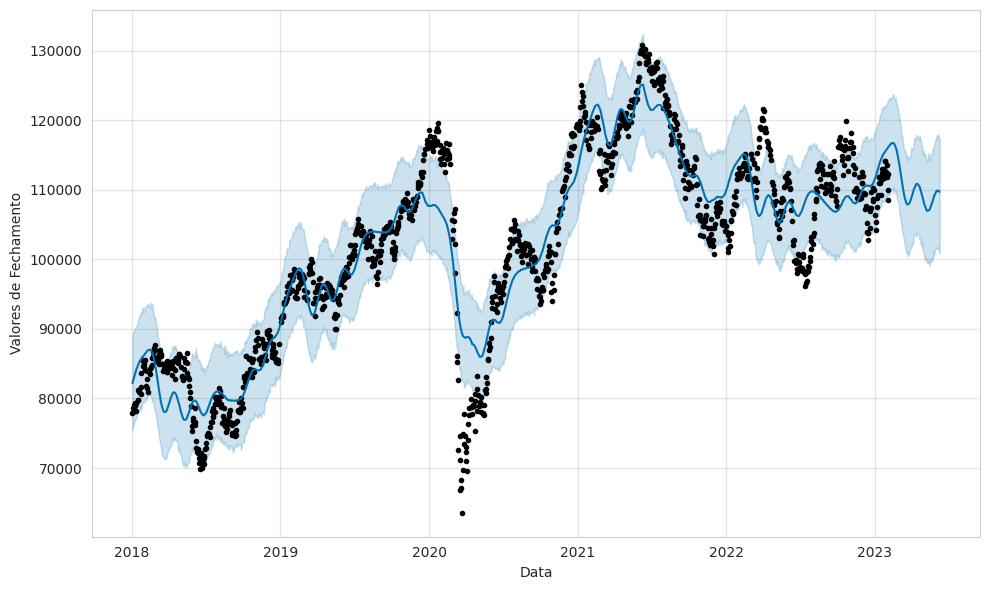

In [328]:
# previsões do modelo treinado.
model2.plot(forecast2, xlabel = 'Data', ylabel = 'Valores de Fechamento')
plt.show()

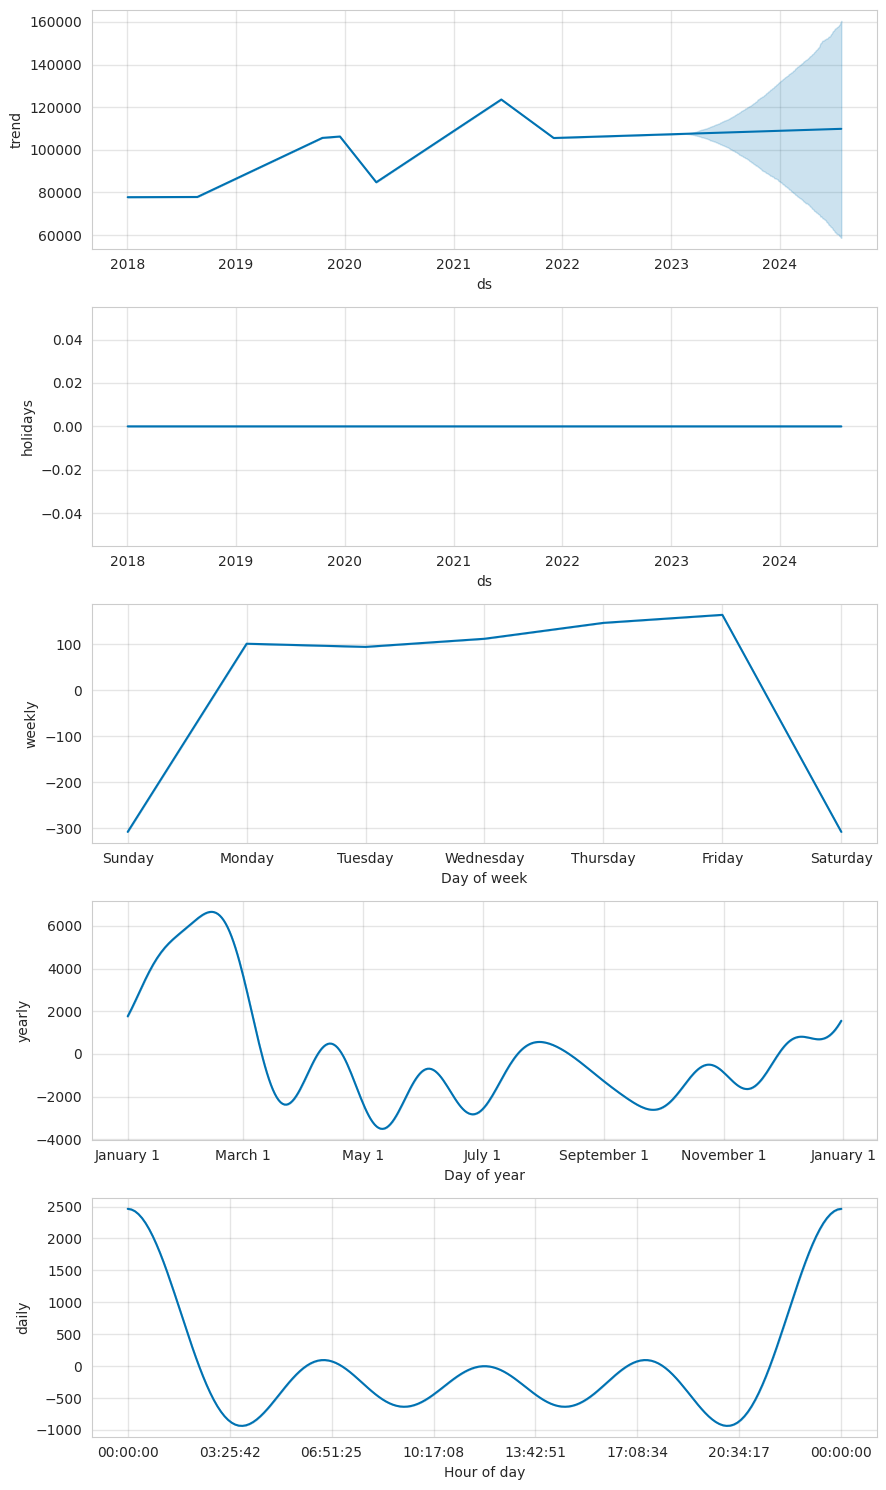

In [329]:
# verificando os componentes.
fig2 = model2.plot_components(forecast)

In [330]:
previsao2 = forecast2[['ds', 'yhat']]
valores_reais2 = train_data[['ds', 'y']]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais.
resultados2 = pd.merge(previsao2, valores_reais2, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados.
resultados2['erro_percentual_absoluto'] = np.abs((resultados2['y'] - resultados2['yhat']) / resultados2['y']) * 100

# Calcular o MAPE.
mape = np.mean(resultados2['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 4.11%


##modelo prophet 4 - MAPE 4.33

In [331]:
#Treinando o modelo com dados de treino e prevendo nos dados de teste.
model4 = Prophet(daily_seasonality=True)
model4.fit(train_data)
prediction = model4.predict(pd.DataFrame({'ds':test_data['ds']}))

y_actual = test_data['y']
y_predicted = prediction['yhat']
y_predicted = y_predicted.astype(int)
print(mean_absolute_error(y_actual, y_predicted))


DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/qrb4h2p9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/o9kkp0tl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19', 'data', 'file=/tmp/tmpw8zhb_nh/qrb4h2p9.json', 'init=/tmp/tmpw8zhb_nh/o9kkp0tl.json', 'output', 'file=/tmp/tmpw8zhb_nh/prophet_modelu6cz1hz8/prophet_model-20240127225935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:59:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


8086.412556053811


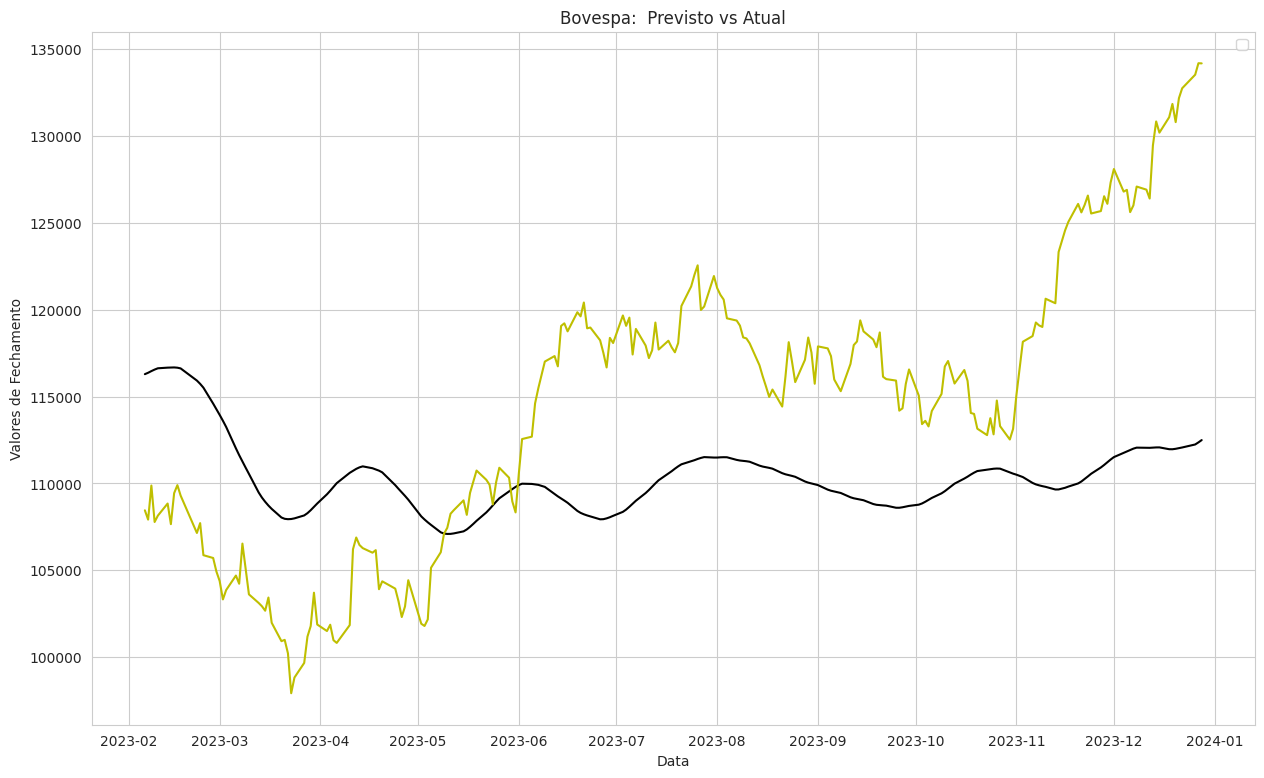

In [332]:
plt.plot(test_data['ds'], y_predicted, 'k')
plt.plot(test_data['ds'], y_actual, 'y')
plt.xlabel("Data")
plt.ylabel("Valores de Fechamento")
plt.title("Bovespa:  Previsto vs Atual")
plt.legend()
plt.show()

In [333]:
#previsao de futuro.
model4 = Prophet()
model4.fit(df_prophet)
future = model4.make_future_dataframe(365)
forecast4 = model4.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/qh2flijs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/ltwozb15.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6570', 'data', 'file=/tmp/tmpw8zhb_nh/qh2flijs.json', 'init=/tmp/tmpw8zhb_nh/ltwozb15.json', 'output', 'file=/tmp/tmpw8zhb_nh/prophet_modelsioy7zyy/prophet_model-20240127225937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:59:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


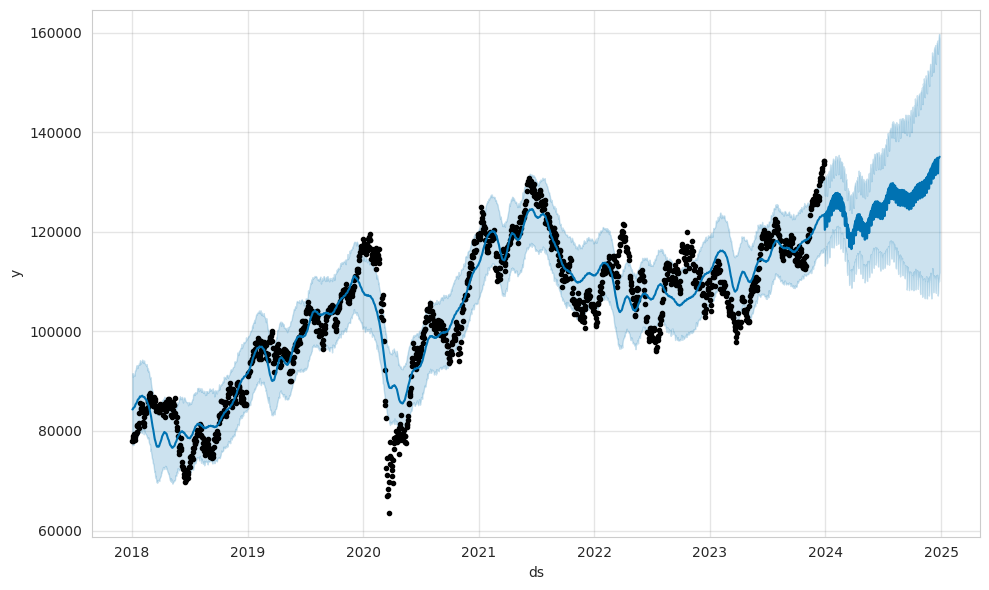

In [334]:
model4.plot(forecast4)
plt.show()

In [335]:
previsao4 = forecast4[['ds', 'yhat']]
valores_reais4 = train_data[['ds', 'y']]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais.
resultados4 = pd.merge(previsao4, valores_reais4, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados.
resultados4['erro_percentual_absoluto'] = np.abs((resultados4['y'] - resultados4['yhat']) / resultados4['y']) * 100

# Calcular o MAPE.
mape = np.mean(resultados4['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 4.33%


##modelo prophet 5 - MAPE 5.73


In [336]:
# definindo uma data de corte.
data_limite = '2023-01-01'
train2 = df_prophet.loc[df_prophet['ds'] <= data_limite]
test2 = df_prophet.loc[df_prophet['ds'] > data_limite]

In [337]:
# contando a quantidade de dias à frente para checar a acurácia da previsão.
dias_a_prever = len(test2.ds.unique())
dias_a_prever

248

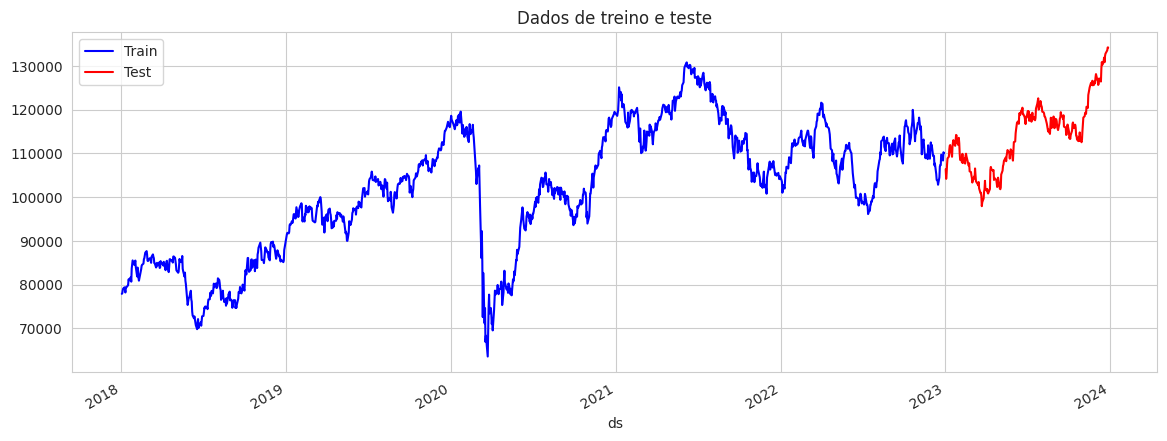

In [338]:
# visualizando os dois dataframes de train e test.
f, ax = plt.subplots(figsize=(14,5))
train2.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
test2.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Dados de treino e teste')
plt.show()

Usaremos a métrica MAPE-Mean absolute percentage error, que indica o quanto do ajuste está errado percentualmente.

In [339]:
# criando a função MAPE.
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Agora vamos fazer uma previsão com os dados que separamos, seguindo o mesmo processo apresentado acima. Primeiro, com os dados de treino vamos prever um período à frente.

In [340]:
# instanciando o modelo, treinando e fazendo a previsão.
model5 = Prophet()
model5.fit(train2)
future5 = model5.make_future_dataframe(periods=dias_a_prever)
forecast5 = model5.predict(future5)

# plotando os resultados das previsões com os dados de treino.
forecast5[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/du8jeeq6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/q2guapn7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7459', 'data', 'file=/tmp/tmpw8zhb_nh/du8jeeq6.json', 'init=/tmp/tmpw8zhb_nh/q2guapn7.json', 'output', 'file=/tmp/tmpw8zhb_nh/prophet_model5kyl__za/prophet_model-20240127225940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:59:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds      yhat  yhat_lower  yhat_upper
1481 2023-08-30 114604.11    96081.23   132845.78
1482 2023-08-31 114569.00    95884.30   132052.17
1483 2023-09-01 114567.77    97903.45   132706.68
1484 2023-09-02 113107.73    96749.19   130848.23
1485 2023-09-03 113053.01    95251.31   132461.34

  Observando os componentes.

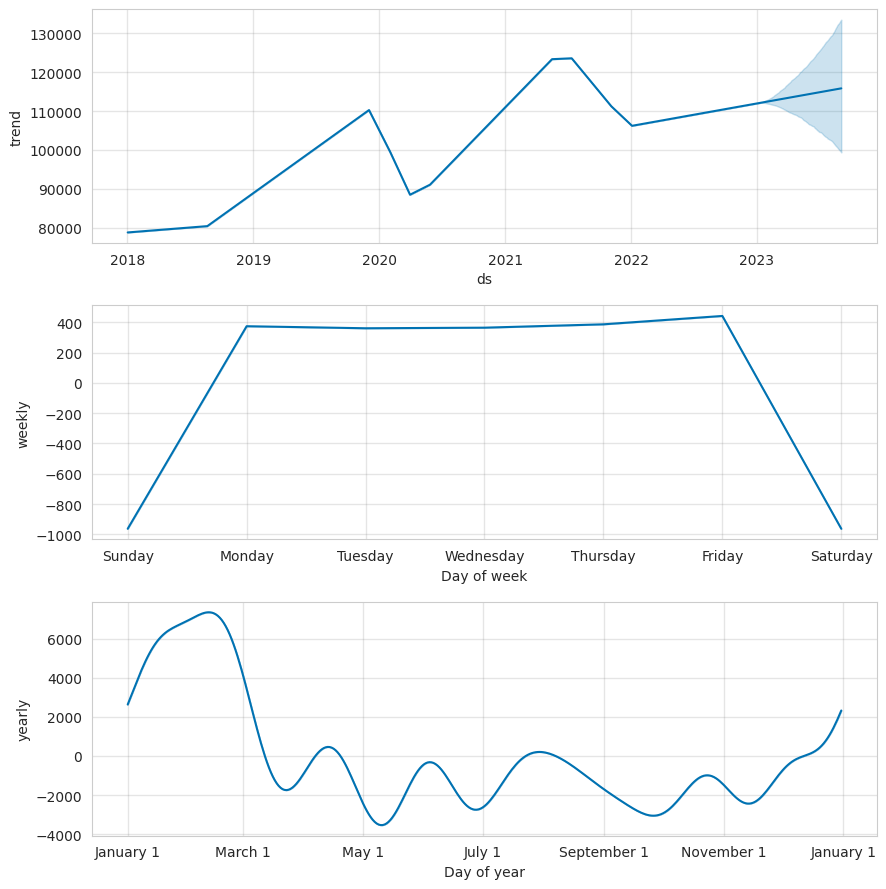

In [341]:
# Plotando os componentes
fig3 = model5.plot_components(forecast5)

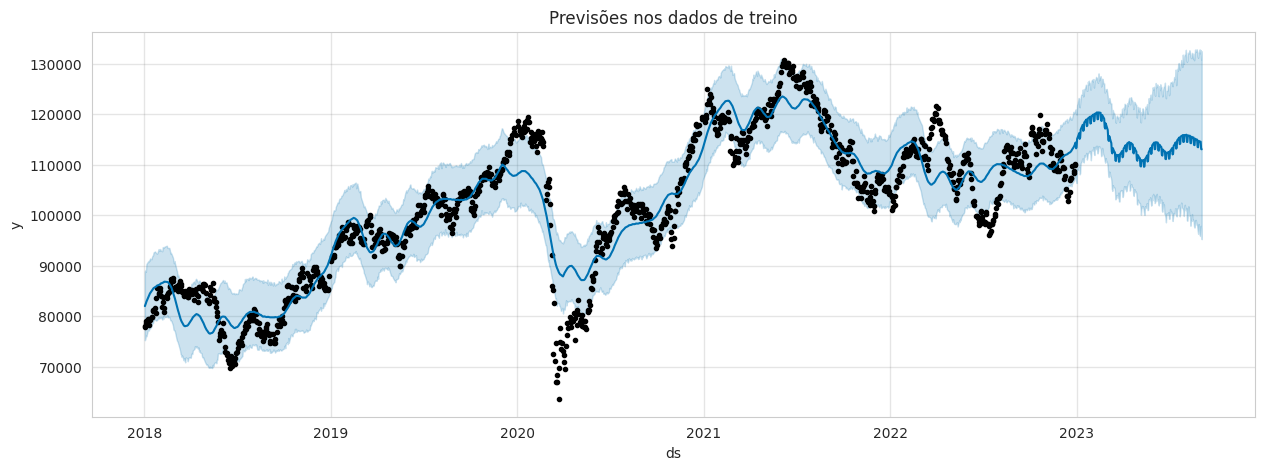

In [342]:
# Plotando as previsões nos dados de treino.
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model5.plot(forecast5, ax=ax)
plt.title('Previsões nos dados de treino');

Agora vamos utilizar os dados de teste.

In [343]:
# fazendo previsões com os dados de teste.
test_forecast = model5.predict(test2)
test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

ds      yhat  yhat_lower  yhat_upper
238 2023-12-14 117893.53    89881.79   146039.36
239 2023-12-15 118002.53    90525.54   146131.93
240 2023-12-18 118129.97    89638.13   146311.03
241 2023-12-19 118199.19    90896.18   146693.15
242 2023-12-20 118297.31    90604.23   146572.88
243 2023-12-21 118426.78    89445.94   148085.28
244 2023-12-22 118603.44    90797.46   148377.92
245 2023-12-26 119162.39    88813.04   148797.77
246 2023-12-27 119365.14    90142.14   149122.28
247 2023-12-28 119600.71    89896.96   148889.28

Vamos plotar os dados da previsão com o real e comparar o quanto o modelo errou.

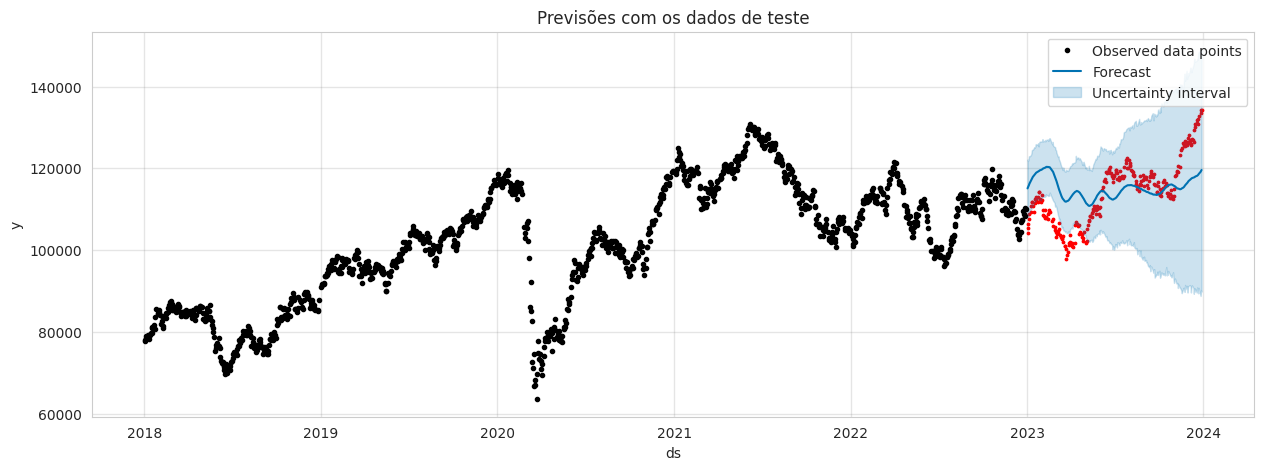

In [344]:
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
ax.scatter(test2.ds, test2['y'], color='r', s=3)
fig = model5.plot(test_forecast, ax=ax)
plt.title('Previsões com os dados de teste')
plt.legend(loc='best')

Podemos ver que visualmente que o modelo não performou tão mal, porém temos que checar as métricas. Antes, vamos olhar somente a parte acrescentada, comparando os dados de teste com as previsões.

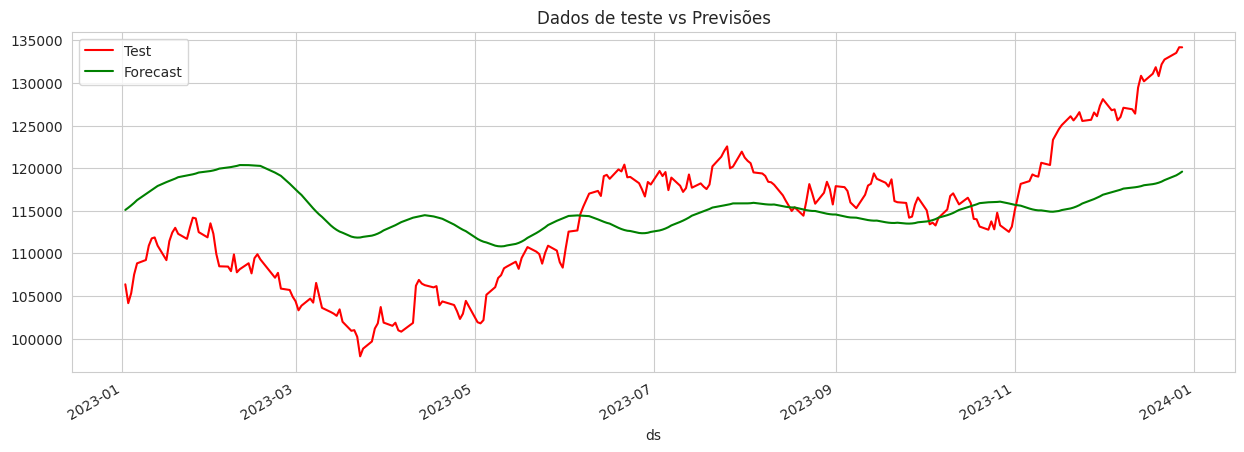

In [345]:
# plotando o gráfico com dados de teste x previsões.

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test2.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Dados de teste vs Previsões')
plt.legend(loc='best')

Verificando com o MAPE para saber o percentual de erro do modelo.

In [346]:
mape = mean_absolute_percentage_error(test2['y'],test_forecast['yhat'])
print("MAPE {:.2f}%".format(round(mape,4)))

MAPE 5.73%


O Cross Validation é muito utilizado para avaliação de desempenho dos modelos.

## modelo prophet 6

In [347]:
df_prophet  = df_bovespa.sort_index().copy()

In [348]:
df_prophet

y
ds                  
2018-01-02  77891.00
2018-01-03  77995.00
2018-01-04  78647.00
2018-01-05  79071.00
2018-01-08  79379.00
...              ...
2023-12-21 132182.00
2023-12-22 132753.00
2023-12-26 133533.00
2023-12-27 134194.00
2023-12-28 134185.00

[1486 rows x 1 columns]

In [349]:
train_data = df_prophet.loc[df_prophet.index > '2019-01-01']
test_data = df_prophet.loc[(df_prophet.index >= '2023-01-01') & (df_prophet.index< '2023-12-31')]
h = test_data.index.nunique()

In [350]:
h

248

In [351]:
train_data

y
ds                  
2019-01-02  91012.00
2019-01-03  91564.00
2019-01-04  91841.00
2019-01-07  91699.00
2019-01-08  92032.00
...              ...
2023-12-21 132182.00
2023-12-22 132753.00
2023-12-26 133533.00
2023-12-27 134194.00
2023-12-28 134185.00

[1241 rows x 1 columns]

In [352]:
test_data

y
ds                  
2023-01-02 106376.00
2023-01-03 104166.00
2023-01-04 105334.00
2023-01-05 107518.00
2023-01-06 108836.00
...              ...
2023-12-21 132182.00
2023-12-22 132753.00
2023-12-26 133533.00
2023-12-27 134194.00
2023-12-28 134185.00

[248 rows x 1 columns]

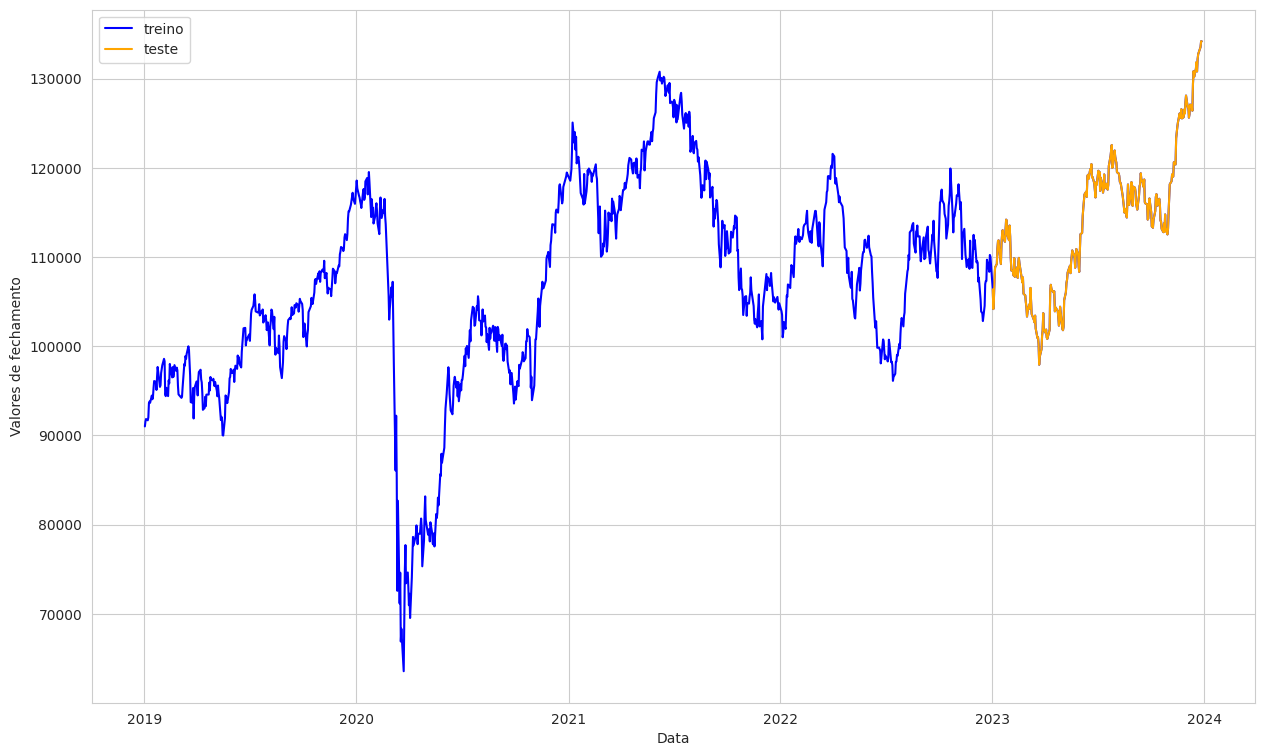

In [353]:
plt.plot(train_data,label='treino',color='blue')
plt.plot(test_data,label='teste',color='orange')
plt.legend()
plt.ylabel('Valores de fechamento')
plt.xlabel('Data')
plt.show()

In [354]:
# instanciar o modelo.
model6 = Prophet(daily_seasonality=True)


# treinar o modelo.
model6.fit(train_data.reset_index())
data_futura_test6 = model6.make_future_dataframe(periods=120, freq='B')

DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/6e62m8_l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/_tinm83x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23745', 'data', 'file=/tmp/tmpw8zhb_nh/6e62m8_l.json', 'init=/tmp/tmpw8zhb_nh/_tinm83x.json', 'output', 'file=/tmp/tmpw8zhb_nh/prophet_model7r3d87vm/prophet_model-20240127225945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:59:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [355]:
previsao6 = model6.predict(data_futura_test6)
previsao6.head()

ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-01-02 90404.75    88991.23   102235.85     90404.75     90404.75   
1 2019-01-03 90454.50    89120.19   102434.02     90454.50     90454.50   
2 2019-01-04 90504.25    88964.00   102525.47     90504.25     90504.25   
3 2019-01-07 90653.49    89347.46   102164.42     90653.49     90653.49   
4 2019-01-08 90703.24    89792.41   103148.20     90703.24     90703.24   

   additive_terms  additive_terms_lower  additive_terms_upper   daily  ...  \
0         5071.32               5071.32               5071.32 1478.42  ...   
1         5272.47               5272.47               5272.47 1478.42  ...   
2         5343.93               5343.93               5343.93 1478.42  ...   
3         5313.47               5313.47               5313.47 1478.42  ...   
4         5437.50               5437.50               5437.50 1478.42  ...   

   weekly  weekly_lower  weekly_upper  yearly  yearly_lower  yearly_upper  \
0    5.98          5.98          5.98 3586.92       3586.92       3586.92   
1  166.38        166.38        166.38 3627.67       3627.67       3627.67   
2  190.75        190.75        190.75 3674.77       3674.77       3674.77   
3  -21.65        -21.65        -21.65 3856.70       3856.70       3856.70   
4   28.15         28.15         28.15 3930.93       3930.93       3930.93   

   multiplicative_terms  multiplicative_terms_lower  \
0                  0.00                        0.00   
1                  0.00                        0.00   
2                  0.00                        0.00   
3                  0.00                        0.00   
4                  0.00                        0.00   

   multiplicative_terms_upper     yhat  
0                        0.00 95476.08  
1                        0.00 95726.97  
2                        0.00 95848.18  
3                        0.00 95966.96  
4                        0.00 96140.74  

[5 rows x 22 columns]

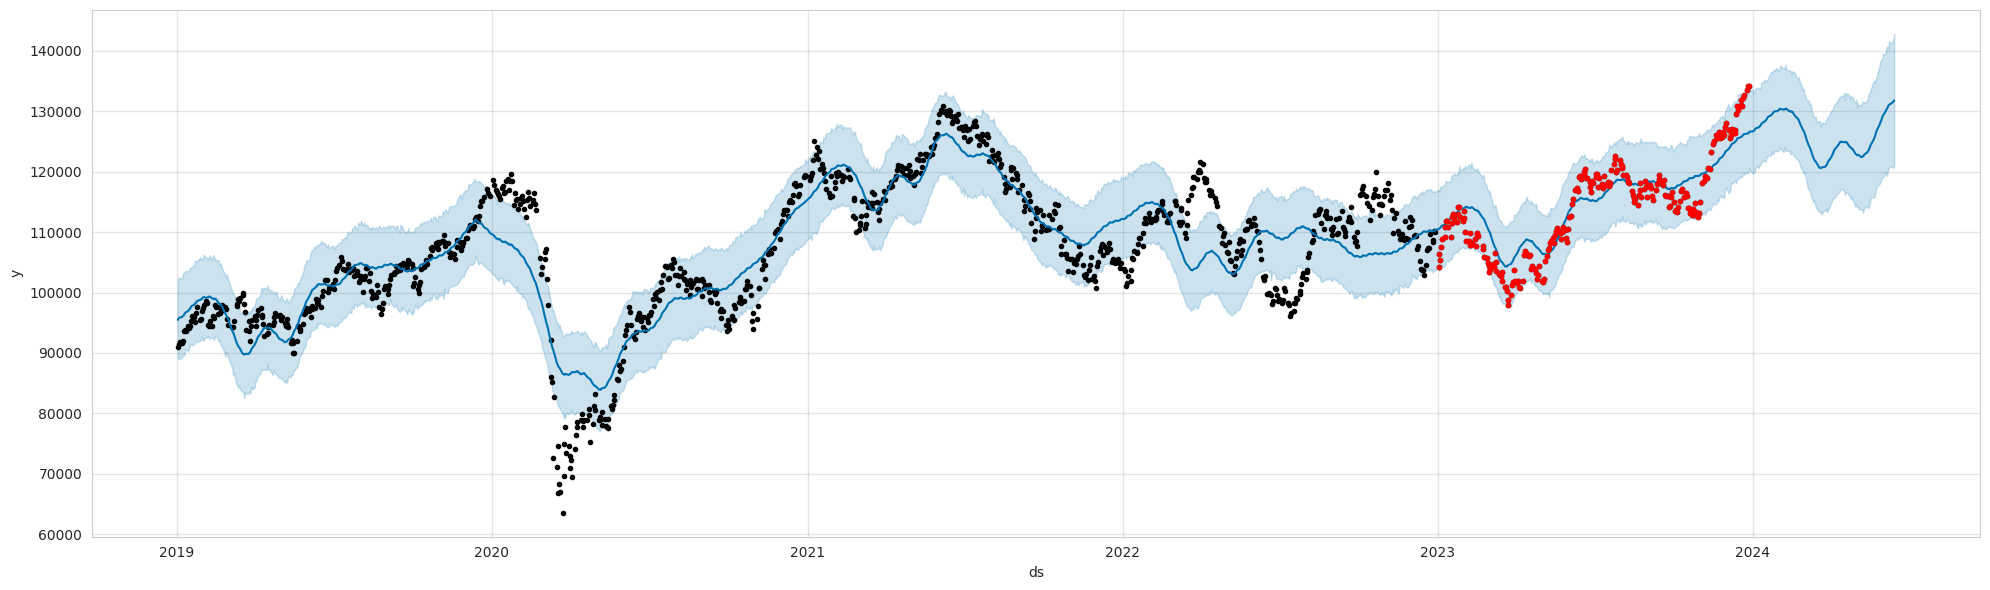

In [356]:
model6.plot(previsao6, figsize=(20,6));
plt.plot(test_data.index, test_data['y'], '.r')
plt.show()

In [357]:
previsao6[['ds','yhat','yhat_lower','yhat_upper']]

ds      yhat  yhat_lower  yhat_upper
0    2019-01-02  95476.08    88991.23   102235.85
1    2019-01-03  95726.97    89120.19   102434.02
2    2019-01-04  95848.18    88964.00   102525.47
3    2019-01-07  95966.96    89347.46   102164.42
4    2019-01-08  96140.74    89792.41   103148.20
...         ...       ...         ...         ...
1356 2024-06-07 131053.07   120744.44   141568.43
1357 2024-06-10 131306.73   120844.31   141131.75
1358 2024-06-11 131470.80   120645.00   141516.31
1359 2024-06-12 131542.88   120592.08   141786.74
1360 2024-06-13 131778.14   121035.52   142772.86

[1361 rows x 4 columns]

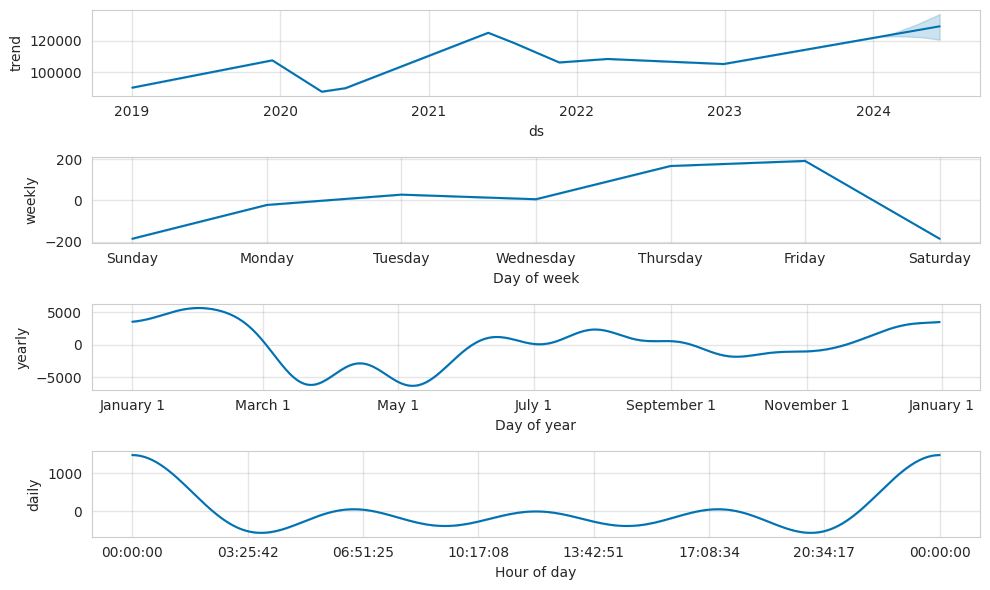

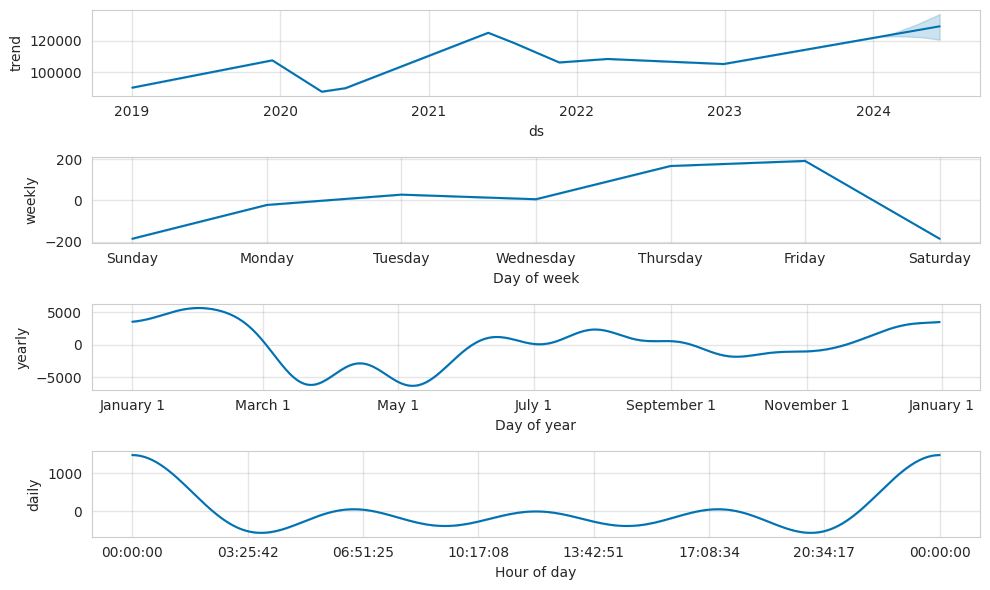

In [358]:
model6.plot_components(previsao6, figsize=(10,6))

In [359]:
# Extrair as colunas relevantes dos DataFrames.
valores_previsao6 = previsao6[['ds','yhat']]
valores_reais6 = train_data[['y']]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais.
resultados6 = pd.merge(valores_previsao6, valores_reais6.reset_index('ds'), on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados.
resultados6['erro_percentual_absoluto'] = np.abs((resultados6['y'] - resultados6['yhat']) / resultados6['y']) * 100

# Calcular o MAPE.
mape = np.mean(resultados6['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}")

MAPE: 3.76


In [360]:
resultados6

ds      yhat         y  erro_percentual_absoluto
0    2019-01-02  95476.08  91012.00                      4.90
1    2019-01-03  95726.97  91564.00                      4.55
2    2019-01-04  95848.18  91841.00                      4.36
3    2019-01-07  95966.96  91699.00                      4.65
4    2019-01-08  96140.74  92032.00                      4.46
...         ...       ...       ...                       ...
1236 2023-12-21 126095.49 132182.00                      4.60
1237 2023-12-22 126192.96 132753.00                      4.94
1238 2023-12-26 126288.31 133533.00                      5.43
1239 2023-12-27 126326.76 134194.00                      5.86
1240 2023-12-28 126548.27 134185.00                      5.69

[1241 rows x 4 columns]

In [361]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model5, previsao6)

In [362]:
plot_components_plotly(model6,previsao6)

In [363]:
# metricas
score_mae = mean_absolute_error(valores_reais['y'].tail(len(test_data.index)), valores_previsao6['yhat'].tail(len(test_data.index)))
score_rmse = math.sqrt(mean_squared_error(valores_reais['y'].tail(len(test_data.index)), valores_previsao6['yhat'].tail(len(test_data.index))))
print('MAE: {}'.format(score_mae))
print('RMSE: {}'.format(score_rmse))



MAE: 12890.60956278051
RMSE: 14642.208002061727


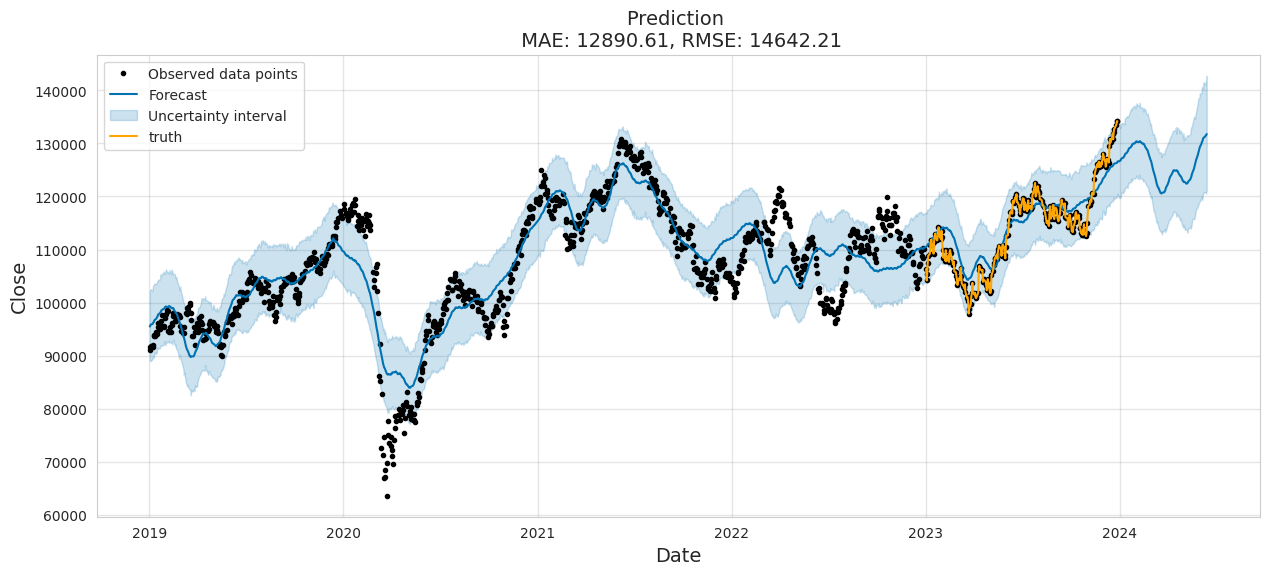

In [364]:
# Plotar o forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model6.plot(previsao6, ax=ax)
sns.lineplot(x=test_data.index, y=test_data['y'], ax=ax, color='orange', label='truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Close', fontsize=14)

plt.show()

In [365]:
# validação cruzada

df_prophet_cv2 = cross_validation(model6, horizon = '90 days')

INFO:prophet:Making 31 forecasts with cutoffs between 2020-01-18 00:00:00 and 2023-09-29 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/h2k0ruo_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/zkox1ae9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94593', 'data', 'file=/tmp/tmpw8zhb_nh/h2k0ruo_.json', 'init=/tmp/tmpw8zhb_nh/zkox1ae9.json', 'output', 'file=/tmp/tmpw8zhb_nh/prophet_model6k8cxqk9/prophet_model-20240127225951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:59:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/8_qogph5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8zhb_nh/3i7dd8_c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [366]:
df_prophet_cv2.head()

ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2020-01-20 118541.82   117071.52   120132.72 118862.00 2020-01-18
1 2020-01-21 118749.41   117329.01   120246.49 117026.00 2020-01-18
2 2020-01-22 118767.64   117151.75   120324.45 118391.00 2020-01-18
3 2020-01-23 119275.08   117738.65   120870.88 119528.00 2020-01-18
4 2020-01-24 119425.67   117970.16   120959.44 118376.00 2020-01-18

In [367]:
# métricas de desempenho da validação cruzada.
from prophet.diagnostics import performance_metrics
df_prophet_p2 = performance_metrics(df_prophet_cv2)
df_prophet_p2.head(10)


horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 10 days  51436625.50  7171.93 5411.20  0.05   0.04   0.05      0.53
1 11 days  53956975.75  7345.54 5605.35  0.05   0.04   0.05      0.53
2 12 days  57152937.97  7559.96 5813.85  0.06   0.04   0.06      0.52
3 13 days  66167060.74  8134.31 6180.29  0.06   0.05   0.06      0.49
4 14 days  74948015.54  8657.25 6561.61  0.06   0.05   0.06      0.48
5 15 days  83867114.63  9157.90 6890.69  0.07   0.05   0.07      0.46
6 16 days  94331394.54  9712.44 7307.31  0.07   0.05   0.07      0.43
7 17 days 105121803.01 10252.89 7708.28  0.08   0.05   0.07      0.39
8 18 days 104395232.03 10217.40 7740.10  0.08   0.06   0.08      0.39
9 19 days 108715593.87 10426.68 7997.01  0.08   0.06   0.08      0.36

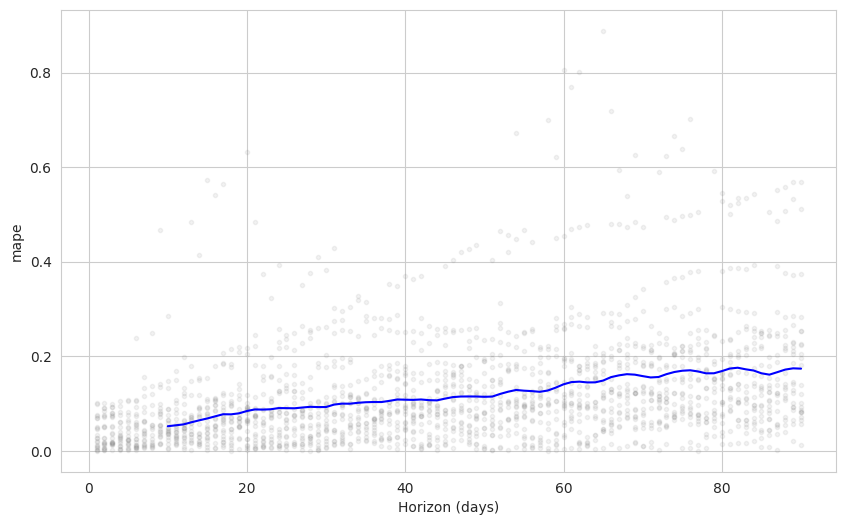

In [368]:
# plotando o mape.
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_prophet_cv2, metric='mape')


https://valquiria-c-alencar.medium.com/time-series-forecasting-prophet-%C3%A9-mesmo-um-profeta-d3356f7b943f

https://carlos-bonfim.medium.com/previs%C3%A3o-de-pre%C3%A7os-com-prophet-748d12b82baa

#3 - LSTM

##modelo LSTM 1

https://www.kaggle.com/code/kmkarakaya/lstm-understanding-the-number-of-parameters

https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm

LSTM (Long Short-Term Memory) é um tipo de rede neural recorrente (RNN) que é projetada para lidar com o problema do desaparecimento do gradiente em RNNs tradicionais. As redes LSTM são capazes de aprender e lembrar informações de longo prazo, o que as torna especialmente eficazes em tarefas que envolvem sequências de dados, como processamento de linguagem natural, reconhecimento de fala e tradução automática.

A principal diferença entre as LSTMs e as RNNs tradicionais é a adição de unidades de memória chamadas "células". Cada célula possui três portas: a porta de entrada, a porta de esquecimento e a porta de saída. Essas portas controlam o fluxo de informações dentro da célula, permitindo que a LSTM aprenda quais informações devem ser lembradas e quais devem ser esquecidas.

A porta de entrada determina quais informações devem ser atualizadas na célula de memória. A porta de esquecimento controla quais informações antigas devem ser esquecidas. E a porta de saída determina quais informações da célula de memória devem ser usadas para gerar a saída.

Essa arquitetura de células e portas permite que as LSTMs capturem dependências de longo prazo em sequências de dados, tornando-as mais eficazes em tarefas que exigem a compreensão de contextos mais amplos.

In [369]:
# criando o dataframe.
df_lstm = df_bovespa.copy()
data = (df_lstm.values).reshape(-1,1)

In [370]:
# Normalizando os dados com MinMaxScaler, os dados vão ficar entre 0 e 1.
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.20277809],
       [0.20425068],
       [0.21348267],
       ...,
       [0.99064058],
       [1.        ],
       [0.99987256]])

In [371]:
# dividindo os dados.
train_size = int(len(scaled_data)*0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [372]:
# criando sequência para predição.

def create_sequences(data, sequence_length):
  X, y =[],[]
  for i in range(len(data) - sequence_length - 1):
    X.append(data[i:(i + sequence_length), 0])
    y.append(data[i + sequence_length, 0])
  return np.array(X), np.array(y)



In [373]:
sequence_length = 10 # tamanho da sequência
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [374]:
# Construindo  e treinando o modelo.
model = Sequential([
    LSTM(50, return_sequences=True, activation='relu',input_shape=(sequence_length, 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=1)

Epoch 1/20
1177/1177 [==============================] - 10s 7ms/step - loss: 0.0061
Epoch 2/20
1177/1177 [==============================] - 7s 6ms/step - loss: 0.0020
Epoch 3/20
1177/1177 [==============================] - 8s 7ms/step - loss: 0.0014
Epoch 4/20
1177/1177 [==============================] - 10s 8ms/step - loss: 0.0011
Epoch 5/20
1177/1177 [==============================] - 7s 6ms/step - loss: 8.8334e-04
Epoch 6/20
1177/1177 [==============================] - 8s 7ms/step - loss: 9.2725e-04
Epoch 7/20
1177/1177 [==============================] - 7s 6ms/step - loss: 7.9999e-04
Epoch 8/20
1177/1177 [==============================] - 10s 8ms/step - loss: 8.0254e-04
Epoch 9/20
1177/1177 [==============================] - 8s 7ms/step - loss: 7.8909e-04
Epoch 10/20
1177/1177 [==============================] - 7s 6ms/step - loss: 7.7981e-04
Epoch 11/20
1177/1177 [==============================] - 8s 7ms/step - loss: 7.2933e-04
Epoch 12/20
1177/1177 [==============================]

In [375]:
# Fazendo a previsão
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Fazendo a inversão para escala original
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


9/9 [==============================] - 0s 4ms/step


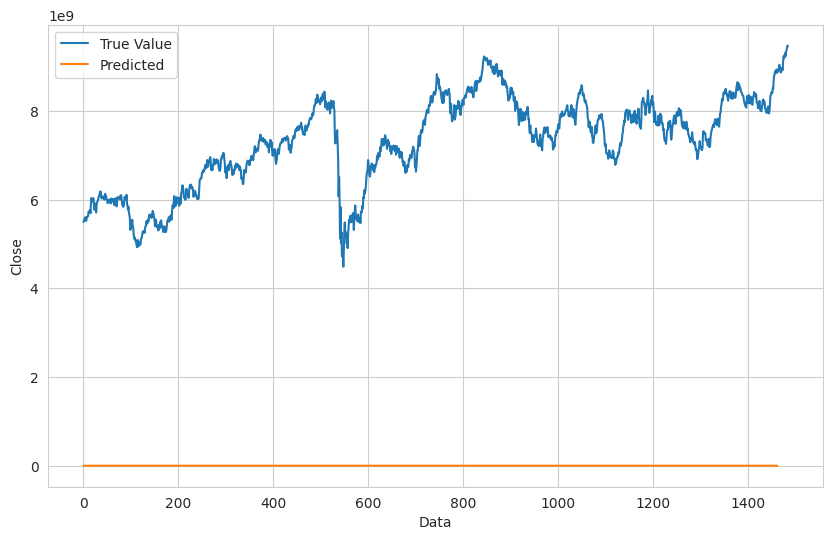

In [376]:
#Plotando predições
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(data), label=  'True Value')
plt.plot(np.concatenate([train_predict, test_predict]), label='Predicted')
plt.xlabel('Data')
plt.ylabel('Close')
plt.legend()
plt.show()

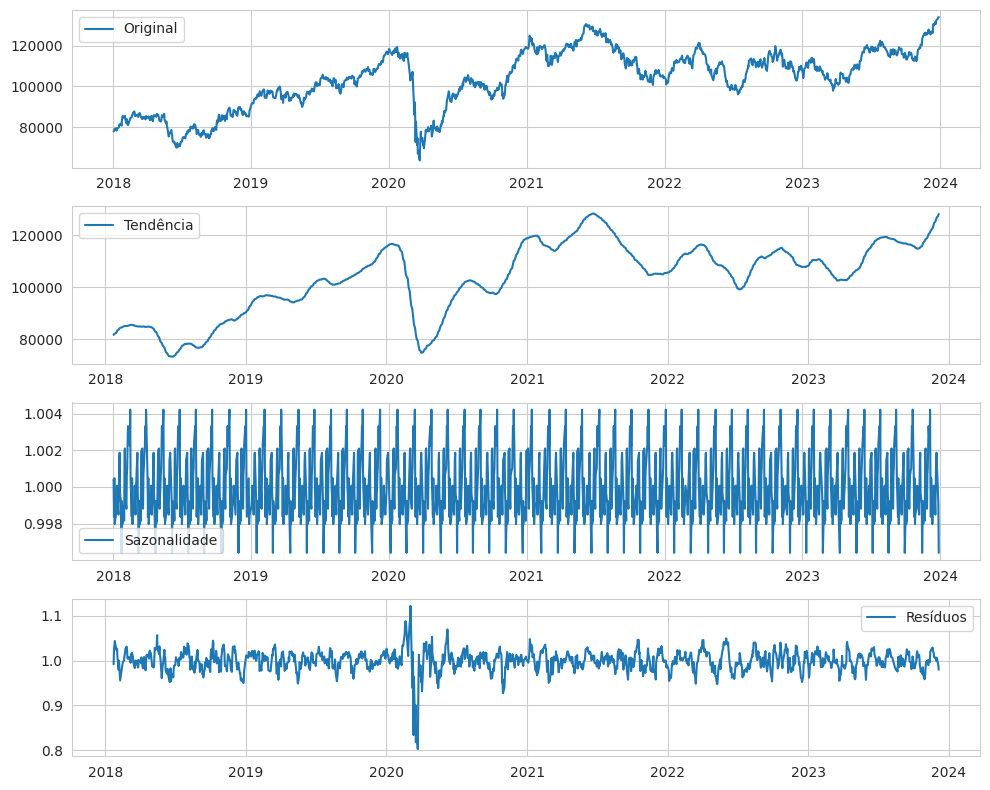

In [377]:
result = seasonal_decompose(df_lstm, model= 'multiplicative', period=30)

# plotando a decomposição.

plt.figure(figsize=(10,8))
plt.subplot(411)
plt.plot(df_lstm, label='Original')
plt.legend()
plt.subplot(412)
plt.plot(result.trend, label='Tendência')
plt.legend()
plt.subplot(413)
plt.plot(result.seasonal, label='Sazonalidade')
plt.legend()
plt.subplot(414)
plt.plot(result.resid, label='Resíduos')
plt.legend()
plt.tight_layout()
plt.show()

O seasonal decompose especifica os padrões e comportamentos sazonais e ajustar os padrões com base nessas informações pode ajudar a melhorar a acurácia.

In [378]:
# definindo o comprimento da sequência
sequence_length = 10

#criando timeseriesgenerator para train e test
train_generator = TimeseriesGenerator(scaled_data,scaled_data,length=sequence_length, batch_size=20 )
test_generator = TimeseriesGenerator(scaled_data,scaled_data, length=sequence_length, batch_size=1 )

# construindo o LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# treinando o modelo usando o generato
model.fit(train_generator, epochs=10)

# prevendo com generator
predicted_values = model.predict(test_generator)

# tranformando previsões para a escala original
predicted_values = scaler.inverse_transform(predicted_values)



Epoch 1/10
74/74 [==============================] - 4s 10ms/step - loss: 0.0315
Epoch 2/10
74/74 [==============================] - 1s 13ms/step - loss: 0.0032
Epoch 3/10
74/74 [==============================] - 1s 16ms/step - loss: 0.0040
Epoch 4/10
74/74 [==============================] - 1s 11ms/step - loss: 0.0031
Epoch 5/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0028
Epoch 6/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0025
Epoch 7/10
74/74 [==============================] - 1s 11ms/step - loss: 0.0024
Epoch 8/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0022
Epoch 9/10
74/74 [==============================] - 1s 11ms/step - loss: 0.0027
Epoch 10/10
1476/1476 [==============================] - 5s 3ms/step


Epoch 1/10
74/74 [==============================] - 1s 11ms/step - loss: 0.0023
Epoch 2/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0021
Epoch 3/10
74/74 [==============================] - 1s 11ms/step - loss: 0.0037
Epoch 4/10
74/74 [==============================] - 1s 12ms/step - loss: 0.0027
Epoch 5/10
74/74 [==============================] - 1s 16ms/step - loss: 0.0020
Epoch 6/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0018
Epoch 7/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0021
Epoch 8/10
74/74 [==============================] - 1s 11ms/step - loss: 0.0017
Epoch 9/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0022
Epoch 10/10
74/74 [==============================] - 1s 11ms/step - loss: 0.0020


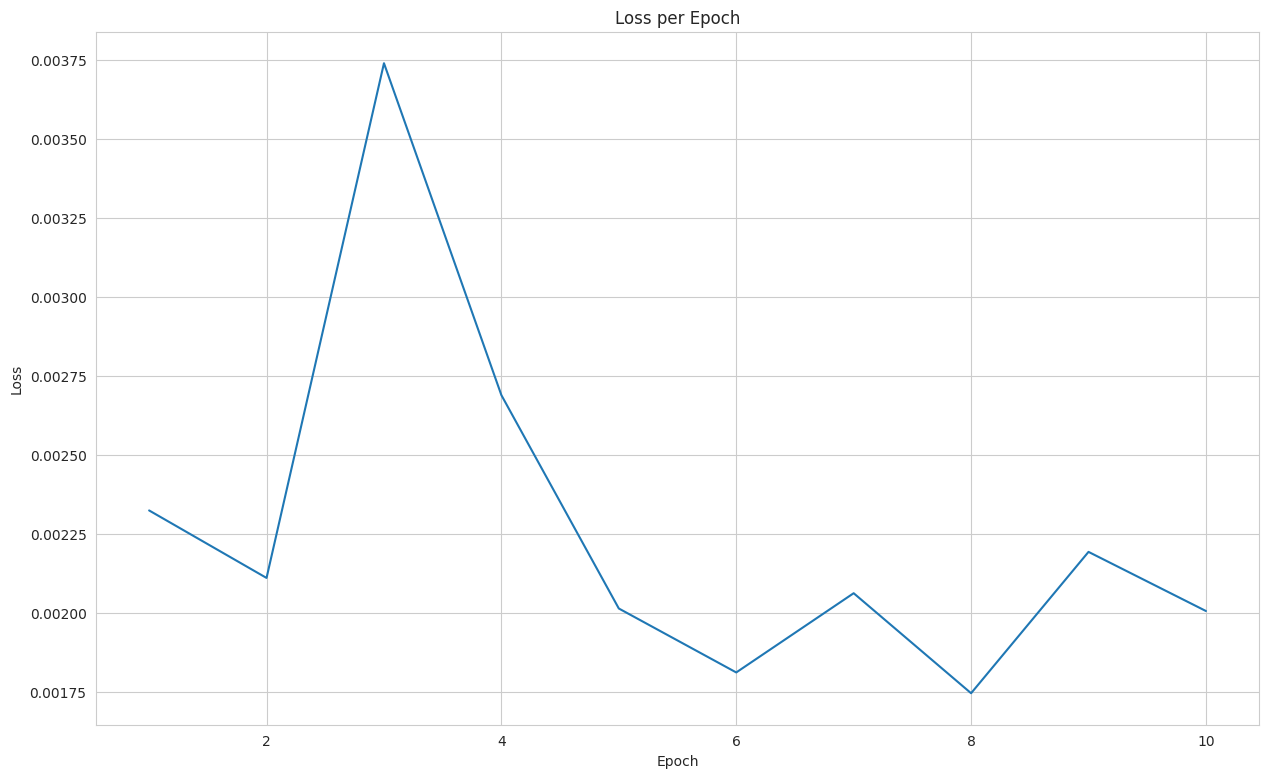

In [379]:
history = model.fit(train_generator, epochs=10, verbose=1)

# perdas por período
loss_per_epoch = history.history['loss']

#plotando
plt.plot(range(1, len(loss_per_epoch)+1), loss_per_epoch)
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Os 'loss' mostram flutuações entre épocas.
Eles parecem estar relativamente próximas umas das outras, indicando que o modelo pode ter alcançado uma certa estabilidade em
treinamento. Parece haver uma tendência decrescente nas perdas e significa que o modelo está aprendendo e melhorando suas previsões.

1/1 [==============================] - 0s 21ms/step


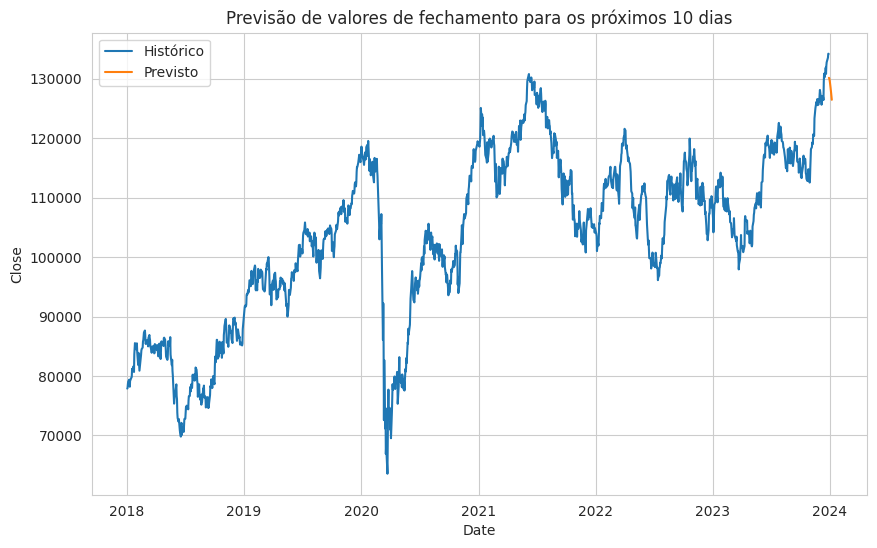

In [380]:
# treinando a última sequencia
last_sequence = scaled_data[-sequence_length:]

# Fazendo previsão para 10 dias
predictions = []
for _ in range(10):
  current_prediction = model.predict(last_sequence.reshape(1, sequence_length, 1))[0, 0]
  predictions.append(current_prediction)
  last_sequence = np.append(last_sequence[1:], current_prediction).reshape(-1, 1)

# Transformando para a escala original
predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# gerando datas para os próximos 10 dias
last_date = df_lstm.index[-1]
dates = pd.date_range(start=last_date, periods=11)[1:]

# Plotting the predicted values for the next 10 days
plt.figure(figsize=(10, 6))
plt.plot(df_lstm.index, df_lstm, label='Histórico')
plt.plot(dates, predicted_values, label='Previsto')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Previsão de valores de fechamento para os próximos 10 dias')
plt.legend()
plt.grid(True)
plt.show()

A função reshape é usada para ajustar a forma do array last_sequence antes de prever o próximo valor na série temporal. Na previsão de séries temporais usando redes neurais recorrentes como LSTM, os dados de entrada precisam estar estruturados em um formato específico que inclui:
1. Amostras: Cada amostra representa uma sequência de pontos de dados. Por exemplo, uma sequência de preços de fechamento passados para Ethereum.
2. Passos de tempo: Cada passo de tempo dentro de uma amostra representa um ponto de dados individual dentro da sequência.
3. Recursos: Estas são as diferentes dimensões ou variáveis presentes em cada passo de tempo. No contexto de modelos LSTM em Keras, os dados de entrada precisam ser tridimensionais (batch_size, time_steps, features). Quando você remodela a last_sequence, você está essencialmente formatando-a na forma que o modelo LSTM espera: (1, sequence_length, 1). Aqui está o motivo pelo qual a remodelação é importante em dados de séries temporais:
4. Formato de entrada do modelo: As redes neurais esperam dados em formas específicas. A remodelação permite que você estruture seus dados corretamente para que se ajustem aos requisitos de entrada do seu modelo.
5. Manipulação de sequência: Para modelos LSTM, a remodelação ajuda a organizar os dados de séries temporais em sequências com passos apropriados. É crucial para preservar o aspecto temporal dos dados.
6. Engenharia de recursos: A remodelação pode ser usada quando você tem múltiplos recursos em seus dados de séries temporais. Ela ajuda a organizar esses recursos de forma que o modelo possa aprender efetivamente. No código fornecido, last_sequence.reshape(1, sequence_length, 1) transforma os dados em uma forma que o modelo LSTM entende: uma única amostra com sequence_length passos de tempo e um recurso por passo. Essa remodelação é vital para manter a estrutura da sequência e garantir que o modelo possa fazer previsões com base nos dados de sequência histórica.

9/9 [==============================] - 0s 5ms/step


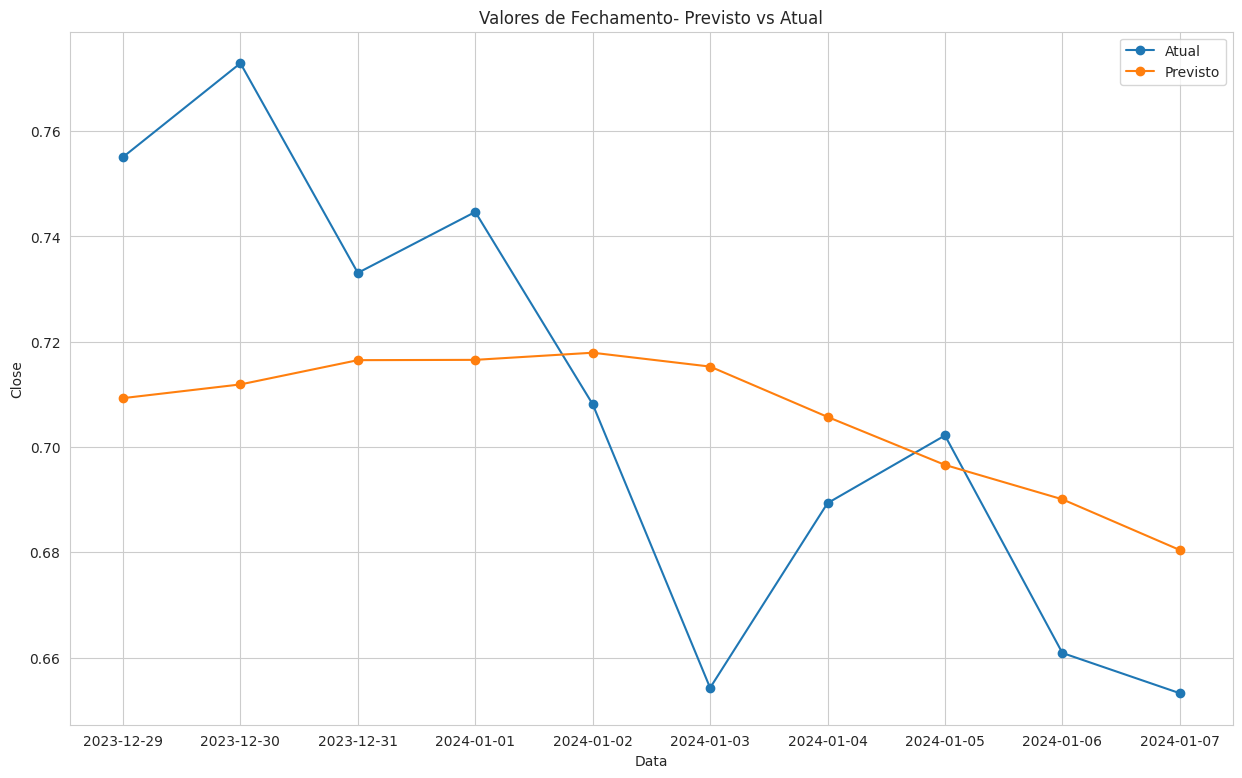

In [381]:
y_pred = model.predict(X_test)

dates_to_plot = dates[:10]

plt.figure(figsize=(15,9))
plt.plot(dates_to_plot, y_test[:10], label='Atual', marker='o')
plt.plot(dates_to_plot, y_pred[:10], label='Previsto', marker='o')
plt.xlabel('Data')
plt.ylabel('Close')
plt.title('Valores de Fechamento- Previsto vs Atual')
plt.legend()
plt.show()

# Select the first 10 predicted values for comparison
y_pred_subset = y_pred[:10].squeeze() # Remove the extra dimension if present

MSE: 0.0012596690645497583
MAE: 0.03006719855577309


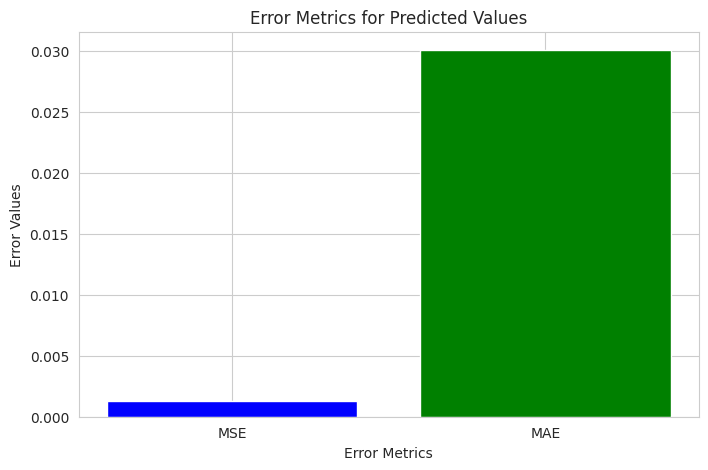

In [382]:
# Calculate error metrics
mse = mean_squared_error(y_test[:10], y_pred_subset)
mae = mean_absolute_error(y_test[:10], y_pred_subset)

# Print the calculated error metrics
print(f"MSE: {mse}")
print(f"MAE: {mae}")

# Plotting error metrics
plt.figure(figsize=(8, 5))
plt.bar(['MSE', 'MAE'], [mse, mae], color=['blue', 'green'])
plt.xlabel('Error Metrics')
plt.ylabel('Error Values')
plt.title('Error Metrics for Predicted Values')
plt.show()


*  O Erro Quadrático Médio (MSE) mede a média dos quadrados dos erros ou desvios, o que dá mais peso para erros grandes. Um MSE menor indica um ajuste melhor entre os valores previstos e os valores reais. Neste caso, o MSE de aproximadamente 8,27-05 sugere que, em média, as diferenças ao quadrado entre os valores previstos e os valores reais são muito pequenas.



*  O Erro Médio Absoluto (MAE) mede as médias das diferenças absolutas entre os valores previstos e os valores reais. Ele fornece uma compreensão mais direta da magnitude média dos erros. Um MAE de cerca de 0,00867 indica que, em média, as previsões do modelo se desviam aproximadamente 0,00867 unidades dos valores reais. Em resumo, ambas as métricas indicam que as previsões do modelo estão relativamente próximas dos valores reais, com pequenas desvios médios entre os valores previstos e os valores reais para o subconjunto de dados fornecido. Valores menores para essas métricas geralmente indicam um melhor desempenho do modelo. No entanto, para avaliar o modelo de forma abrangente, é essencial considerar essas métricas juntamente com outras técnicas de avaliação e em conjuntos de dados maiores, se disponíveis.



## modelo LSTM 2 - modelo by prof.Ana Raquel


In [383]:
import yfinance as yf

# identificando o índice e o período selecionado
symbol = '^BVSP'
start_date = '2018-01-01'
end_date = '2023-12-31'

# download dos dados
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [384]:
df

Open      High       Low     Close  Adj Close   Volume
Date                                                                  
2018-01-02  76403.00  77909.00  76403.00  77891.00   77891.00  2880300
2018-01-03  77889.00  78414.00  77602.00  77995.00   77995.00  3142200
2018-01-04  77998.00  79135.00  77998.00  78647.00   78647.00  3486100
2018-01-05  78644.00  79071.00  78218.00  79071.00   79071.00  2747100
2018-01-08  79070.00  79395.00  78631.00  79379.00   79379.00  2550800
...              ...       ...       ...       ...        ...      ...
2023-12-21 130826.00 132277.00 130822.00 132182.00  132182.00  8681000
2023-12-22 132553.00 133035.00 132094.00 132753.00  132753.00  8231100
2023-12-26 132753.00 133645.00 132753.00 133533.00  133533.00        0
2023-12-27 133523.00 134195.00 133328.00 134194.00  134194.00  6168200
2023-12-28 134194.00 134392.00 133832.00 134185.00  134185.00  7812700

[1486 rows x 6 columns]

In [385]:
df.drop(['Open','High','Low','Adj Close','Volume'], axis=1, inplace=True)
df = df.reset_index('Date')

In [386]:
close_data = df['Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

In [387]:
# Normalizando os dados com MinMaxScaler, os dados vão ficar entre 0 e 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_data)

In [388]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

1188
298


In [389]:
!pip install tensorflow

In [390]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [391]:
look_back = 14

In [392]:
# Gerar sequências temporais
train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [393]:
np.random.seed(42)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
59/59 [==============================] - 2s 11ms/step - loss: 3834800896.0000 - mean_squared_error: 3834801408.0000
Epoch 2/20
59/59 [==============================] - 1s 9ms/step - loss: 23177354.0000 - mean_squared_error: 23177354.0000
Epoch 3/20
59/59 [==============================] - 1s 12ms/step - loss: 18957874.0000 - mean_squared_error: 18957874.0000
Epoch 4/20
59/59 [==============================] - 1s 9ms/step - loss: 16549325.0000 - mean_squared_error: 16549325.0000
Epoch 5/20
59/59 [==============================] - 1s 9ms/step - loss: 22336082.0000 - mean_squared_error: 22336082.0000
Epoch 6/20
59/59 [==============================] - 1s 11ms/step - loss: 17841466.0000 - mean_squared_error: 17841470.0000
Epoch 7/20
59/59 [==============================] - 1s 22ms/step - loss: 16569874.0000 - mean_squared_error: 16569874.0000
Epoch 8/20
59/59 [==============================] - 1s 22ms/step - loss: 16466264.0000 - mean_squared_error: 16466264.0000
Epoch 9/20
59/5

In [394]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio", mse[0])

284/284 [==============================] - 2s 4ms/step - loss: 10918506.0000 - mean_squared_error: 10918506.0000
Erro Quadrático Médio 10918506.0


In [395]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f'MAPE: {mape:.4f}')

284/284 [==============================] - 1s 4ms/step
MAPE: 2.2425


In [396]:
#O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 3304.31626815594


In [397]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Truth'
)
layout = go.Layout(
    title = "Predições da Bovespa",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

284/284 [==============================] - 2s 6ms/step


Consideracoes Finais:

Tanto o Prophet quanto o LSTM são modelos populares para previsão de séries temporais, como a bolsa de valores.

O Prophet é um modelo de previsão desenvolvido pelo Facebook, que é fácil de usar e fornece resultados rápidos e precisos. Ele é baseado em decomposição aditiva de séries temporais, que separa a tendência, sazonalidade e componentes de erro. O Prophet também é capaz de lidar com dados ausentes e outliers de forma robusta. Além disso, ele permite a inclusão de informações adicionais, como feriados e eventos especiais, para melhorar a precisão das previsões.

Por outro lado, o LSTM (Long Short-Term Memory) é um tipo de rede neural recorrente que é capaz de aprender dependências de longo prazo em sequências de dados. Ele é especialmente adequado para previsão de séries temporais, pois é capaz de capturar padrões complexos e não lineares ao longo do tempo. O LSTM é capaz de lembrar informações relevantes de eventos passados e usá-las para fazer previsões futuras.

Ambos os modelos têm suas vantagens e desvantagens, e a escolha entre eles depende do contexto específico e dos dados disponíveis. O Prophet é mais adequado para previsões de curto prazo e quando há informações adicionais relevantes disponíveis. Já o LSTM é mais adequado para previsões de longo prazo e quando há padrões complexos e não lineares nos dados.

É importante ressaltar que a previsão da bolsa de valores é um desafio complexo e incerto, e nenhum modelo pode garantir resultados precisos o tempo todo. Portanto, é recomendado usar esses modelos como ferramentas auxiliares para tomar decisões informadas.